# Skytrax Review EDA & Modeling Prep

This notebook explores and prepares the Skytrax airline review data for machine learning. It is organized into three main sections:

1. **Data Quality Questions**: Assess the completeness, balance, and distributions in the data, including missing values and target variable analysis.
2. **Business-Relevant Questions**: Investigate patterns and relationships relevant to airline operations and customer experience, such as feature correlations and segment differences.
3. **Modeling Preparation Questions**: Identify feature engineering needs, encoding requirements, and risks for modeling, ensuring the data is ready for downstream ML tasks.

Each section contains code and analysis to answer key questions for building robust, business-relevant models.


In [351]:
!pip install pyarrow

In [352]:
# Imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    precision_recall_curve, mean_squared_error, r2_score, mean_absolute_error
)
from scipy.stats import randint, uniform

In [353]:
# Path setup (fix __file__ usage for Jupyter)
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, "../src"))
print("src_path:", src_path)
if src_path not in sys.path:
    sys.path.append(src_path)
print("sys.path:", sys.path)

#  Snowpark session
from connection import get_session
session = get_session()

# Data pull (limit for test, full for EDA)
df = session.table("FCT_REVIEW_ENRICHED").limit(5).to_pandas()
print(df.head())

src_path: /Users/tranmaiphuong/Documents/Airline Project/airline-analytics-project/src
sys.path: ['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/tranmaiphuong/Documents/Airline Project/airline-analytics-project/.venv/lib/python3.12/site-packages', '/Users/tranmaiphuong/Documents/Airline Project/airline-analytics-project/src']
   REVIEW_ID  CUSTOMER_ID DATE_SUBMITTED_ID DATE_FLOWN_ID  ORIGIN_LOCATION_ID  \
0     111768        57680        2020-12-10    2020-12-01                3971   
1     156368        57680        2025-07-06    2025-06-01                3971   
2      83367        57709        2018-08-08    2018-07-01                1056   
3     124834        57710        2022-06-30    2022-06-01                 413   
4      91297        57712        2019-02-07    2019-01-01                 194   

## 1. Data Quality 

In [354]:
# Config variables 
FACT_TABLE = "FCT_REVIEW_ENRICHED"
NUMERIC_COLS = [
    "SEAT_COMFORT", "CABIN_STAFF_SERVICE", "FOOD_AND_BEVERAGES",
    "INFLIGHT_ENTERTAINMENT", "GROUND_SERVICE", "WIFI_AND_CONNECTIVITY",
    "VALUE_FOR_MONEY", "AVERAGE_RATING"
]
CATEGORICAL_COLS = [
    "SEAT_TYPE", "TYPE_OF_TRAVELLER", "RATING_BAND", "AIRLINE"
]
TARGET_COL = "RECOMMENDED"
TARGET_REG = "VALUE_FOR_MONEY"
ID_COLS = [
    "REVIEW_ID", "CUSTOMER_ID", "DATE_SUBMITTED_ID", "DATE_FLOWN_ID",
    "ORIGIN_LOCATION_ID", "DESTINATION_LOCATION_ID", "TRANSIT_LOCATION_ID", "AIRCRAFT_ID"
]

In [355]:
# Data shape checks
df_full = session.table(FACT_TABLE)
row_count = df_full.count()
print("Row count:", row_count)
cols = df_full.columns
print("Column count:", len(cols))


Row count: 121821
Column count: 25


We extract only the numeric ratings, categorical features, and target variable into a Pandas DataFrame for easier exploratory analysis and visualization.

In [356]:
# EDA sample
pdf_sample = df_full.select(*(NUMERIC_COLS + CATEGORICAL_COLS + [TARGET_COL])).to_pandas()
print(pdf_sample.shape)
print(pdf_sample.head())

(121821, 13)
   SEAT_COMFORT  CABIN_STAFF_SERVICE  FOOD_AND_BEVERAGES  \
0           1.0                  1.0                 1.0   
1           1.0                  1.0                 1.0   
2           2.0                  2.0                 2.0   
3           NaN                  NaN                 NaN   
4           1.0                  1.0                 NaN   

   INFLIGHT_ENTERTAINMENT  GROUND_SERVICE  WIFI_AND_CONNECTIVITY  \
0                     1.0             1.0                    1.0   
1                     2.0             1.0                    1.0   
2                     3.0             1.0                    NaN   
3                     NaN             NaN                    NaN   
4                     NaN             1.0                    NaN   

   VALUE_FOR_MONEY  AVERAGE_RATING      SEAT_TYPE TYPE_OF_TRAVELLER  \
0              1.0            1.00  Economy Class          Business   
1              1.0            1.14  Economy Class          Business   
2   

### Missing Values Analysis

In [357]:
# Missing values analysis
missing_pct = pdf_sample.isna().mean().sort_values(ascending=False) * 100
missing_pct = missing_pct.round(2).to_frame("missing_%")
print(missing_pct)

                        missing_%
WIFI_AND_CONNECTIVITY       67.07
INFLIGHT_ENTERTAINMENT      44.07
FOOD_AND_BEVERAGES          29.75
CABIN_STAFF_SERVICE          7.33
GROUND_SERVICE               7.32
SEAT_COMFORT                 6.86
TYPE_OF_TRAVELLER            3.68
SEAT_TYPE                    0.21
VALUE_FOR_MONEY              0.01
AVERAGE_RATING               0.01
RATING_BAND                  0.00
AIRLINE                      0.00
RECOMMENDED                  0.00


- Major gaps: Wi-Fi (67%), Entertainment (44%), Food (30%).  
- Moderate gaps: Comfort, Staff, Ground (~7%).  
- Targets & Airline fields → fully populated.  
- Missingness is structured (e.g., Wi-Fi missing = service not offered).

### Target Balance

In [358]:
# Target normalization and balance
pdf_sample[TARGET_COL] = (
    pdf_sample[TARGET_COL].astype(str).str.lower().isin(["true", "1", "yes"])
).astype(int)
balance = pdf_sample[TARGET_COL].value_counts().rename(index={0:"Not Recommend", 1:"Recommend"})
print("RECOMMENDED counts:\n", balance)
print("\nRECOMMENDED balance (%):\n", (balance / balance.sum() * 100).round(2))
vfm_counts = pdf_sample["VALUE_FOR_MONEY"].value_counts().sort_index()
print("\nVALUE_FOR_MONEY counts:\n", vfm_counts)
print("\nVALUE_FOR_MONEY distribution (%):\n", (vfm_counts / vfm_counts.sum() * 100).round(2))


RECOMMENDED counts:
 RECOMMENDED
Not Recommend    82925
Recommend        38896
Name: count, dtype: int64

RECOMMENDED balance (%):
 RECOMMENDED
Not Recommend    68.07
Recommend        31.93
Name: count, dtype: float64

VALUE_FOR_MONEY counts:
 VALUE_FOR_MONEY
1.0    59145
2.0    14296
3.0    12455
4.0    14205
5.0    21705
Name: count, dtype: int64

VALUE_FOR_MONEY distribution (%):
 VALUE_FOR_MONEY
1.0    48.56
2.0    11.74
3.0    10.23
4.0    11.66
5.0    17.82
Name: count, dtype: float64


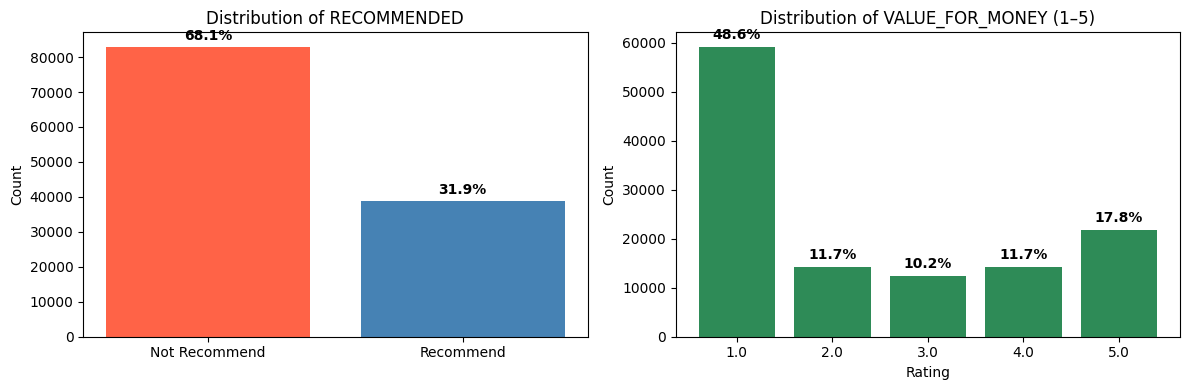

In [359]:
# Plotting (wrap in functions for testability)
def plot_target_distributions(pdf_sample, target_col, vfm_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    counts = pdf_sample[target_col].value_counts().sort_index()
    bars = axes[0].bar(["Not Recommend", "Recommend"], counts, color=["tomato", "steelblue"])
    axes[0].set_title("Distribution of RECOMMENDED")
    axes[0].set_ylabel("Count")
    for bar, count in zip(bars, counts):
        pct = f"{count / counts.sum() * 100:.1f}%"
        axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000,
                     pct, ha="center", va="bottom", fontsize=10, fontweight="bold")
    vfm_counts = pdf_sample[vfm_col].value_counts().sort_index()
    bars = axes[1].bar(vfm_counts.index.astype(str), vfm_counts.values, color="seagreen")
    axes[1].set_title("Distribution of VALUE_FOR_MONEY (1–5)")
    axes[1].set_xlabel("Rating")
    axes[1].set_ylabel("Count")
    for bar, count in zip(bars, vfm_counts):
        pct = f"{count / vfm_counts.sum() * 100:.1f}%"
        axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000,
                     pct, ha="center", va="bottom", fontsize=10, fontweight="bold")
    plt.tight_layout()
    plt.show()

plot_target_distributions(pdf_sample, TARGET_COL, "VALUE_FOR_MONEY")

- **RECOMMENDED:** 68% Not Recommend vs. 32% Recommend → moderate imbalance.  
- **VALUE_FOR_MONEY:** 49% gave 1-star, only 18% gave 5 → strongly skewed negative.  
- Modeling must address imbalance & skew.


### Numeric distributions

In [360]:
# Numeric distributions
desc = pdf_sample[NUMERIC_COLS].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
print(desc)

                           count      mean       std  min   5%  25%  50%  \
SEAT_COMFORT            113465.0  2.556330  1.459289  1.0  1.0  1.0  2.0   
CABIN_STAFF_SERVICE     112894.0  2.824499  1.602820  1.0  1.0  1.0  3.0   
FOOD_AND_BEVERAGES       85580.0  2.561556  1.514173  1.0  1.0  1.0  2.0   
INFLIGHT_ENTERTAINMENT   68139.0  2.505217  1.513802  1.0  1.0  1.0  2.0   
GROUND_SERVICE          112900.0  2.332073  1.584691  1.0  1.0  1.0  1.0   
WIFI_AND_CONNECTIVITY    40118.0  1.930729  1.404135  1.0  1.0  1.0  1.0   
VALUE_FOR_MONEY         121806.0  2.384505  1.584366  1.0  1.0  1.0  2.0   
AVERAGE_RATING          121807.0  2.414711  1.367249  1.0  1.0  1.0  2.0   

                         75%   95%  max  
SEAT_COMFORT            4.00  5.00  5.0  
CABIN_STAFF_SERVICE     4.00  5.00  5.0  
FOOD_AND_BEVERAGES      4.00  5.00  5.0  
INFLIGHT_ENTERTAINMENT  4.00  5.00  5.0  
GROUND_SERVICE          4.00  5.00  5.0  
WIFI_AND_CONNECTIVITY   3.00  5.00  5.0  
VALUE_FOR_MONEY      

- Ratings range 1–5 as expected.  
- Medians mostly 1–2 → generally low scores.  
- Best rated: Cabin Staff (~2.8).  
- Worst: Wi-Fi & Ground Service (~2).  
- Average overall rating = 2.4.

### Segment Sufficiency (Categorical Distributions)

In [361]:
# Segment sufficiency
seg_counts = {}
for cname in CATEGORICAL_COLS:
    seg_counts[cname] = (
        pdf_sample[cname].fillna("<NULL>").value_counts().to_frame("count")
    )
for cname in seg_counts:
    print(f"{cname} distribution:\n", seg_counts[cname].head(), "\n")


SEAT_TYPE distribution:
                   count
SEAT_TYPE              
Economy Class    101539
Business Class    13430
Premium Economy    4538
First Class        2064
<NULL>              250 

TYPE_OF_TRAVELLER distribution:
                    count
TYPE_OF_TRAVELLER       
Solo Leisure       42266
Couple Leisure     30622
Family Leisure     27091
Business           17355
<NULL>              4487 

RATING_BAND distribution:
              count
RATING_BAND       
bad          58718
medium       36699
good         26390
Unknown         14 

AIRLINE distribution:
                    count
AIRLINE                 
American Airlines   5908
Spirit Airlines     4671
United Airlines     4542
Read more           4131
Frontier Airlines   3471 



- **Seat Type:** 83% Economy, small share in premium cabins.  
- **Traveller Type:** Balanced across Solo, Couple, Family; Business smaller (14%).  
- **Rating Band:** Skewed toward Bad (49%).  
- **Airline:** Long-tailed; some carriers 4k+ reviews, many rare. “Read more” entry needs cleaning.

### Target & Feature Distributions

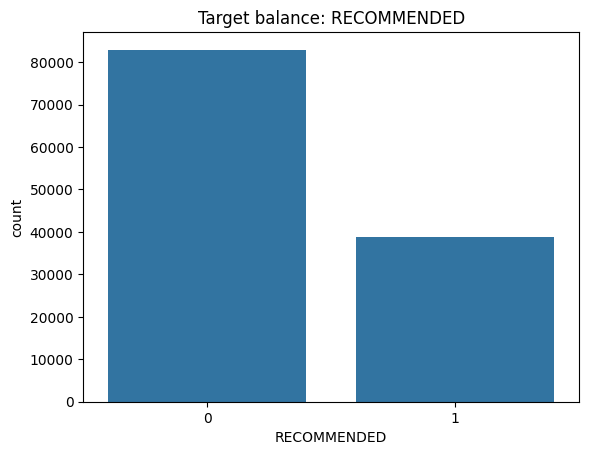

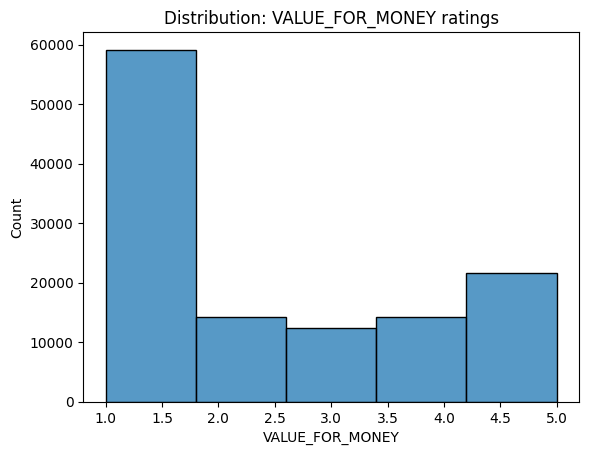

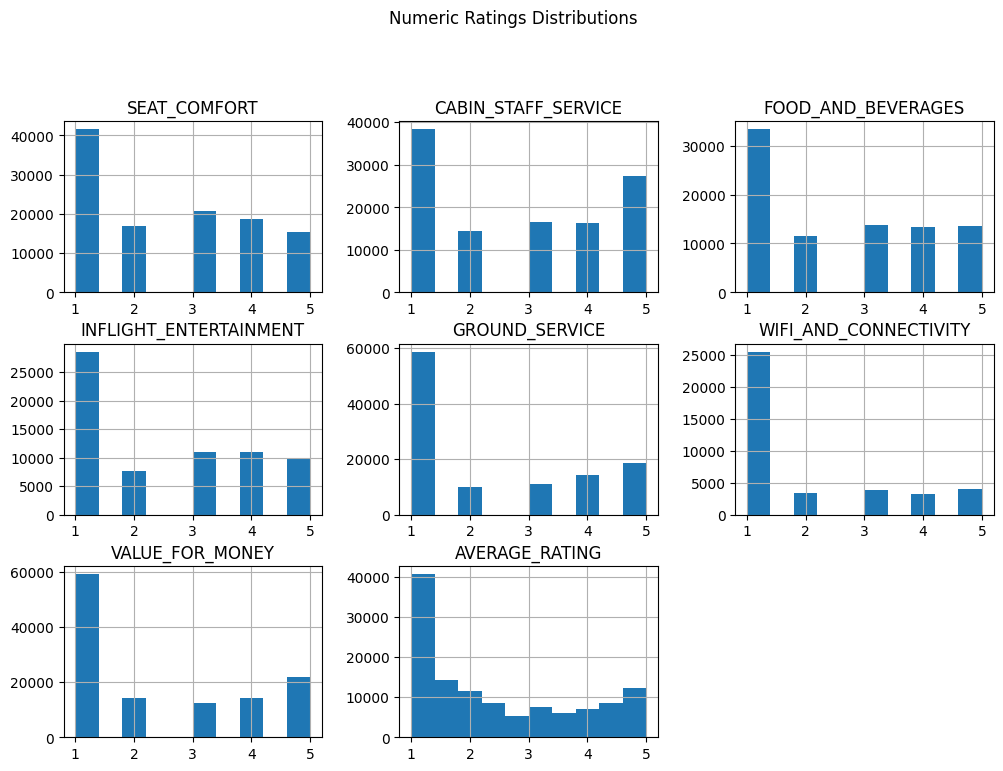

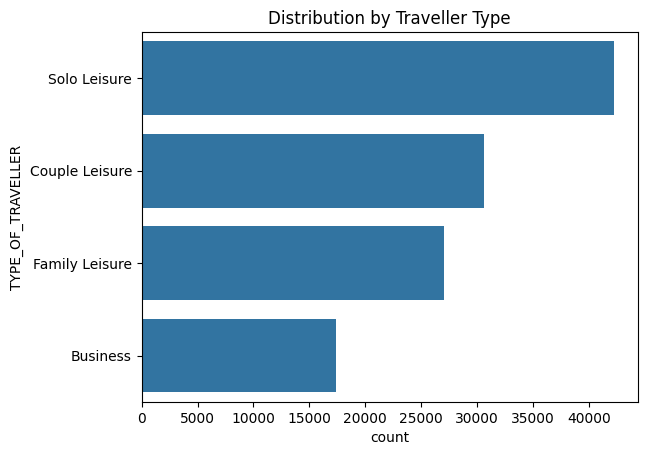

In [362]:
# Plot categorical distributions (testable)
def plot_categorical_distributions(pdf_sample):
    sns.countplot(x=pdf_sample["RECOMMENDED"])
    plt.title("Target balance: RECOMMENDED")
    plt.show()
    sns.histplot(pdf_sample["VALUE_FOR_MONEY"], bins=5, kde=False)
    plt.title("Distribution: VALUE_FOR_MONEY ratings")
    plt.show()
    pdf_sample[NUMERIC_COLS].hist(figsize=(12, 8), bins=10)
    plt.suptitle("Numeric Ratings Distributions", y=1.02)
    plt.show()
    sns.countplot(y=pdf_sample["TYPE_OF_TRAVELLER"], order=pdf_sample["TYPE_OF_TRAVELLER"].value_counts().index)
    plt.title("Distribution by Traveller Type")
    plt.show()

plot_categorical_distributions(pdf_sample)

The plots above illustrate the balance of targets, the spread of numeric ratings, and the sufficiency of categorical segments:

1. **RECOMMENDED (binary target)**  
   - The left chart shows ~68% *Not Recommend* vs. ~32% *Recommend*.  
   - The imbalance is moderate and should be addressed in evaluation (ROC-AUC, F1-score, balanced accuracy).

2. **VALUE_FOR_MONEY (ordinal target)**  
   - Ratings are heavily skewed: nearly half of customers rated value as **1**, while fewer than 20% gave it a **5**.  
   - This aligns with earlier descriptive stats and highlights customer dissatisfaction with value.

3. **Numeric rating features**  
   - Histograms show most sub-ratings are concentrated at the lower end (1–2).  
   - `CABIN_STAFF_SERVICE` is rated somewhat higher compared to others, while `GROUND_SERVICE` and `WIFI_AND_CONNECTIVITY` are consistently low.  
   - No values fall outside the 1–5 scale, confirming validity.

4. **Categorical segment sufficiency (example: Traveller Type)**  
   - Distribution is fairly balanced: Solo (35%), Couple (25%), Family (22%), Business (14%).  
   - This ensures sufficient coverage across traveler types for comparative analysis.

**Key takeaway:** Both targets and most features are strongly skewed toward negative reviews, reflecting customer dissatisfaction. Categorical coverage is adequate (except imbalanced seat classes and long-tailed airlines). These insights will guide feature engineering and model evaluation strategies.


### Part 1: Data Exploration Summary
**1. Data Shape**
- **121,821 rows** and **25 columns**
- Rich set of numeric ratings, categorical labels, and review text.

**2. Missing Values**
- Major gaps:
  - **Wi-Fi & Connectivity** → 67% missing
  - **Inflight Entertainment** → 44%
  - **Food & Beverages** → 30%
- Moderate gaps (7–8%): Seat comfort, cabin staff service, ground service.
- Target (`RECOMMENDED`) and key fields (Airline, Rating Band) are **fully populated**.

**3. Target Balance**
- **RECOMMENDED (binary classification)**
  - 68% = Not Recommend
  - 32% = Recommend
  - Imbalanced (roughly 2:1), may need stratified sampling or class weights.
- **VALUE_FOR_MONEY (regression, 1–5)**
  - Skewed toward **1-star (49%)**
  - 18% gave 5-star, others spread thinly across 2–4.

**4. Numeric Ratings**
- Most service ratings (1–5 scale) are **skewed low** (many 1s).
- Example: Wi-Fi mean = 1.9, Cabin Staff mean = 2.8.
- Average rating across flights = ~2.4, with long tail to 5.

**5. Segment Distributions**
- **Seat Type**
  - Economy: 101K (dominant)
  - Business: 13K
  - Premium Economy: 4.5K
  - First Class: 2K
- **Traveller Type**
  - Solo Leisure: 42K
  - Couple Leisure: 30K
  - Family Leisure: 27K
  - Business: 17K
- **Rating Band**
  - Bad: 58.7K
  - Medium: 36.7K
  - Good: 26.4K
- **Airlines**
  - Large representation from multiple carriers (e.g., American 5.9K, Spirit 4.7K, United 4.5K, Frontier 3.5K).
  
**6. Key Takeaways**
- **Plenty of data** for modeling (120K+ rows).
- Need to handle **missing service ratings** (especially Wi-Fi & entertainment).
- Targets:
  - Classification: `RECOMMENDED` (imbalanced but workable).
  - Regression: `VALUE_FOR_MONEY` (heavily skewed toward 1).
- Data is dominated by **Economy class & leisure travelers**, which may bias models.



---

## 2. Business-Relevant Questions

**TL,DR: Executive Summary**:  
Customer satisfaction is driven primarily by **core service elements** (staff, food, comfort, ground service), with **amenities like Wi-Fi and IFE secondary**. High-volume U.S. carriers underperform on recommend rates, while **premium Asian/Middle Eastern airlines lead**. Satisfaction rises with **cabin class** and is highest among **solo travelers**, while families rate both value and recommendation lowest. Negative reviews cluster around major U.S. carriers and repeat under-performance appears at **STN, LTN, DEN, MCO, CLT** airports. For business action, airlines should **prioritize core service improvements**, **raise Economy and Family Leisure satisfaction**, **benchmark performance by rate and count**, and **target underperforming airports** with dedicated programs.


**2.1 Which features have the strongest correlation with VALUE_FOR_MONEY and RECOMMENDED?**

We explored how service-related ratings (seat comfort, staff service, food, etc.) correlate with the two key target variables:  
- **VALUE_FOR_MONEY** (1–5 ordinal rating)  
- **RECOMMENDED** (binary: 0 = Not Recommend, 1 = Recommend)  

A correlation heatmap was computed across all numeric features and targets:  

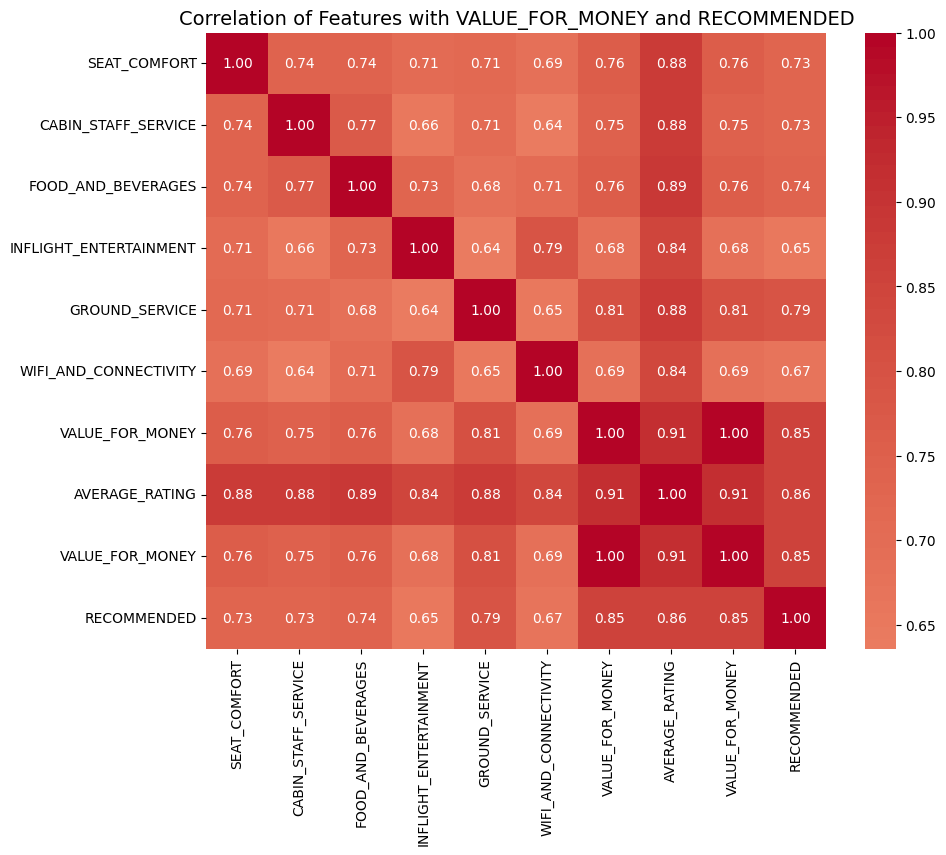

In [363]:
# Correlation heatmap (testable)
corr_pdf = pdf_sample.copy()
corr_pdf["RECOMMENDED"] = (
    corr_pdf["RECOMMENDED"].astype(str).str.lower().isin(["true","1","yes"])
).astype(int)
corr_matrix = corr_pdf[NUMERIC_COLS + ["VALUE_FOR_MONEY", "RECOMMENDED"]].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation of Features with VALUE_FOR_MONEY and RECOMMENDED", fontsize=14)
plt.show()


**Key Findings:**  
- **Average Rating** shows the **strongest correlation** with both targets (0.88 with VALUE_FOR_MONEY, 0.86 with RECOMMENDED).  
- **Ground Service, Food & Beverages, and Cabin Staff Service** also have strong positive relationships (0.75–0.81 range).  
- **Wi-Fi & Connectivity** is positively correlated but weaker (0.65–0.69).  
- Overall, all service features are **positively associated** with customer perception of value and recommendation, but **not equally influential**.  

**Business Insight:** Improving **core in-flight and ground services** (seat comfort, staff, food, ground service) appears more impactful on recommendation likelihood than focusing only on Wi-Fi or entertainment. This aligns with the idea that **basic service quality drives loyalty**, while extras provide incremental value.  

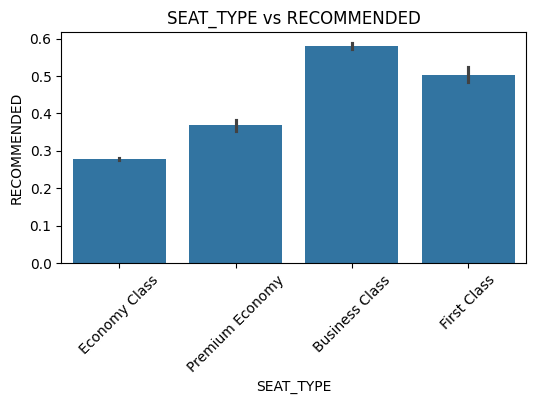

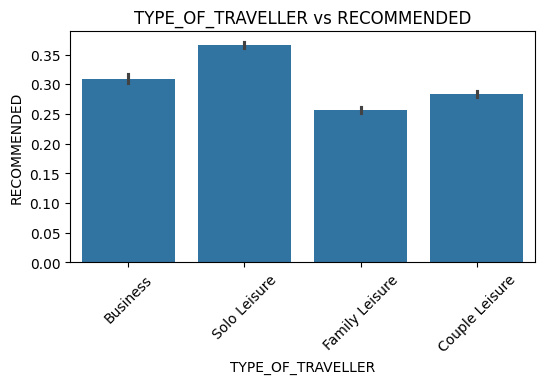

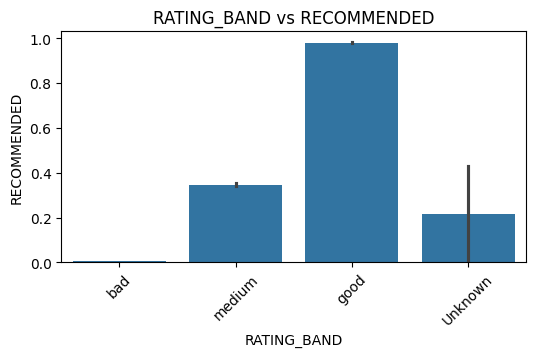

In [364]:
# Bar plots for categorical features vs RECOMMENDED
for col in CATEGORICAL_COLS:
    if col == "AIRLINE":
        continue
    plt.figure(figsize=(6,3))
    sns.barplot(x=pdf_sample[col], y=pdf_sample[TARGET_COL])
    plt.title(f"{col} vs RECOMMENDED")
    plt.xticks(rotation=45)
    plt.show()

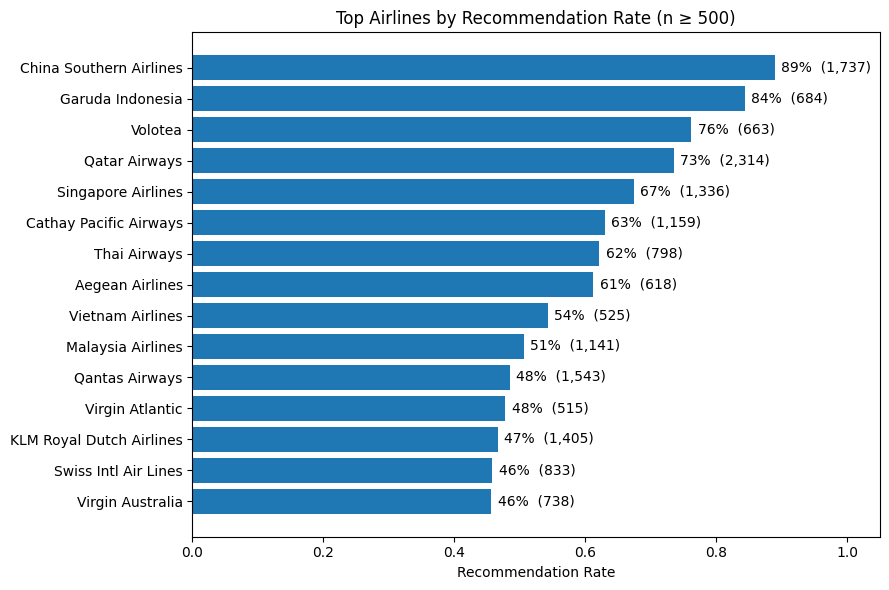

In [365]:
# Airline aggregation (testable)
TOP_N = 15
MIN_COUNT = 500
CLEAN_BAD_VALUES = {"Read more", "", None}
air = pdf_sample.copy()
air["AIRLINE"] = air["AIRLINE"].replace(list(CLEAN_BAD_VALUES), np.nan)
air = air.dropna(subset=["AIRLINE"])
agg = (air
       .groupby("AIRLINE", as_index=False)["RECOMMENDED"]
       .agg(recommend_rate="mean", n="size"))
agg = agg.query("n >= @MIN_COUNT")
best = (agg.query("n >= @MIN_COUNT")
          .sort_values(["recommend_rate", "n"], ascending=[False, False])
          .head(TOP_N)
          .sort_values("recommend_rate", ascending=True))
plt.figure(figsize=(9, 6))
bars = plt.barh(best["AIRLINE"], best["recommend_rate"])
for bar, rate, n in zip(bars, best["recommend_rate"], best["n"]):
    x = bar.get_width()
    plt.text(x + 0.01, bar.get_y() + bar.get_height()/2,
             f"{rate:.0%}  ({n:,})", va="center", fontsize=10)
plt.xlabel("Recommendation Rate")
plt.title("Top Airlines by Recommendation Rate (n ≥ 500)")
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()


#### Correlation Insights  
- **Average Rating** is the strongest driver of both VALUE_FOR_MONEY (0.88) and RECOMMENDED (0.86).  
- **Ground Service, Food & Beverages, and Cabin Staff Service** also show strong positive correlations (0.75–0.81).  
- **Wi-Fi & Connectivity** is weaker (0.65–0.69), suggesting amenities matter less than core service quality.  

#### Airline-Level Insights  
Two complementary views highlight the gap between volume and satisfaction:  
- **By Volume:** Major carriers (American, United, Delta, Spirit, Frontier) dominate reviews but have **low recommendation rates (12–29%)**.  
- **By Recommendation Rate (≥500 reviews):** Premium carriers stand out — **China Southern (89%)**, **Garuda Indonesia (84%)**, **Qatar (73%)**, and **Singapore (67%)** achieve much higher satisfaction.  

#### Takeaway  
Customer loyalty is driven more by **service quality** than amenities. Large carriers face widespread dissatisfaction, while premium airlines show that **consistent quality drives strong recommendation rates**.  

**2.2 Do economy passengers rate lower on VALUE_FOR_MONEY than premium cabins?**

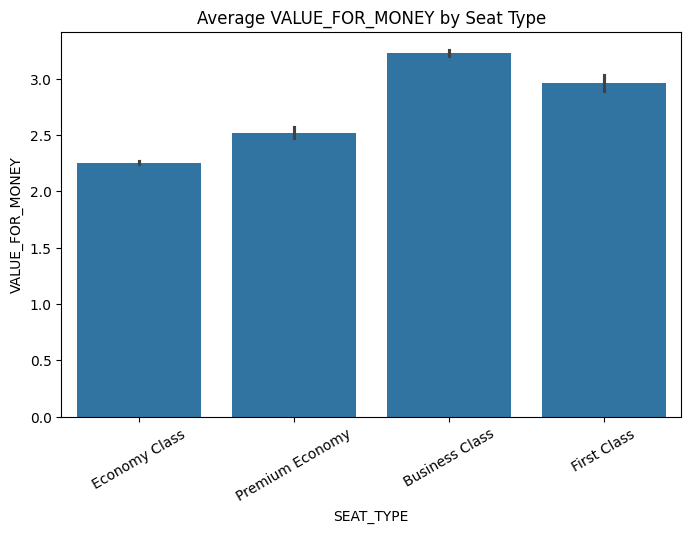

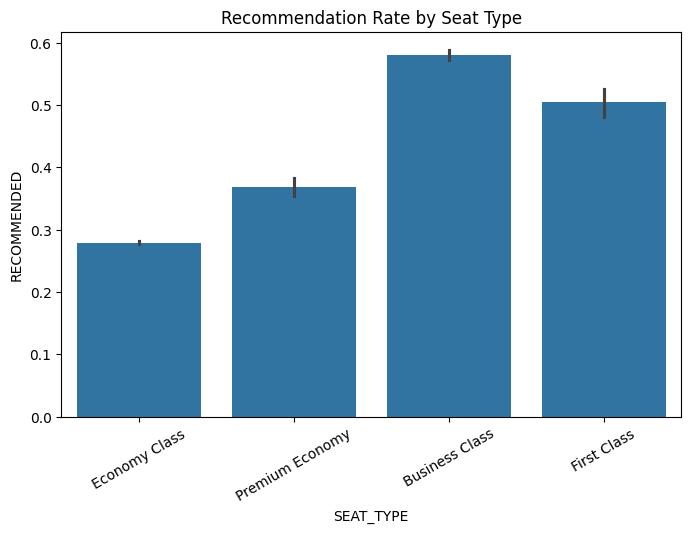

In [366]:
# Average VALUE_FOR_MONEY by seat type
plt.figure(figsize=(8,5))
sns.barplot(x="SEAT_TYPE", y="VALUE_FOR_MONEY", data=pdf_sample)
plt.title("Average VALUE_FOR_MONEY by Seat Type")
plt.xticks(rotation=30)
plt.show()

# Recommend rate by seat type
plt.figure(figsize=(8,5))
sns.barplot(x="SEAT_TYPE", y="RECOMMENDED", data=corr_pdf, estimator=lambda x: sum(x)/len(x))
plt.title("Recommendation Rate by Seat Type")
plt.xticks(rotation=30)
plt.show()



**2.3 Do traveller segments (business/leisure/family/solo) differ in satisfaction?**

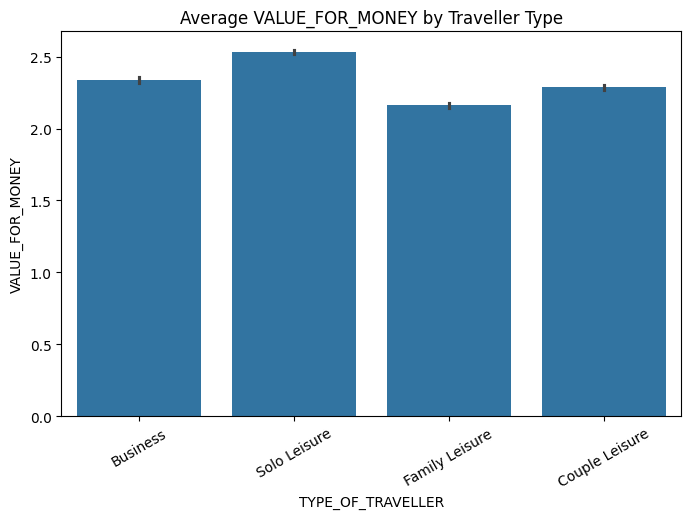

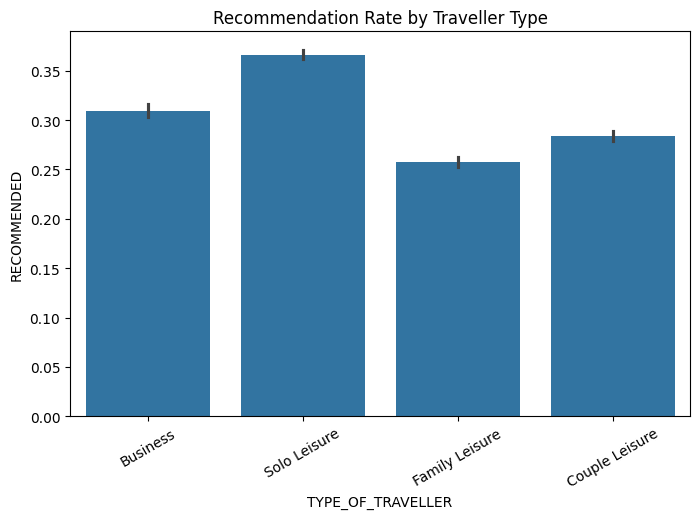

In [367]:
# VALUE_FOR_MONEY by traveller type
plt.figure(figsize=(8,5))
sns.barplot(x="TYPE_OF_TRAVELLER", y="VALUE_FOR_MONEY", data=pdf_sample)
plt.title("Average VALUE_FOR_MONEY by Traveller Type")
plt.xticks(rotation=30)
plt.show()

# Recommend rate by traveller type
plt.figure(figsize=(8,5))
sns.barplot(x="TYPE_OF_TRAVELLER", y="RECOMMENDED", data=corr_pdf, estimator=lambda x: sum(x)/len(x))
plt.title("Recommendation Rate by Traveller Type")
plt.xticks(rotation=30)
plt.show()


**Findings:**
- **VALUE_FOR_MONEY**: Economy passengers rate significantly lower (~2.3) compared to Premium Economy (~2.5), Business (~3.2), and First Class (~3.0).  
- **Recommendation Rate**: Economy has the lowest recommendation rate (~28%), while Business (~58%) and First (~51%) perform much higher. Premium Economy sits in the middle (~37%).  

**Key Takeaway:**  
Economy passengers consistently feel they receive the least value and are least likely to recommend. Premium cabins, particularly Business Class, deliver higher perceived value and stronger loyalty, justifying their pricing premium.

### 2.4 Top Airlines by Negative Reviews (may add this)

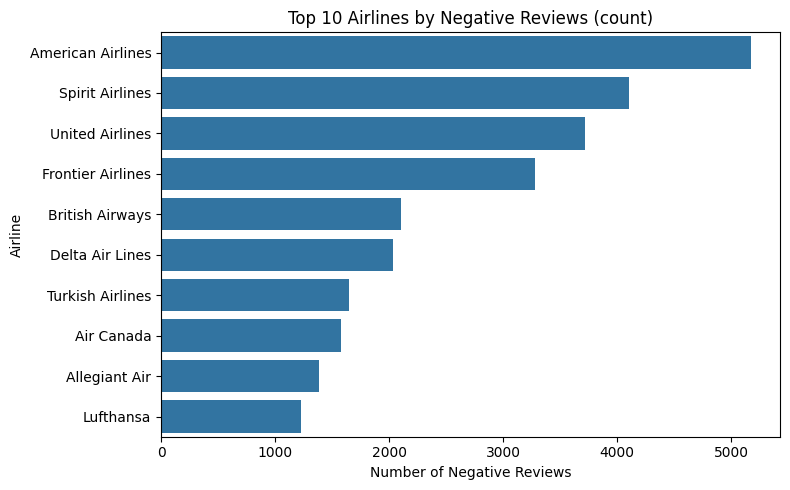

In [368]:
# Filter for not recommended
neg_pdf = corr_pdf[corr_pdf["RECOMMENDED"] == 0].copy()

# Clean obvious junk airline labels
neg_pdf["AIRLINE"] = neg_pdf["AIRLINE"].replace(
    {"Read more": None, "Frontier Airlines3810 Reviews": None, "": None}
)
neg_pdf = neg_pdf.dropna(subset=["AIRLINE"])

# Top airlines by negative reviews (count)
top_airlines = (
    neg_pdf.groupby("AIRLINE")
           .size()
           .sort_values(ascending=False)
           .head(10)
)

# Plot (horizontal for readability)
plt.figure(figsize=(8,5))
sns.barplot(y=top_airlines.index.astype(str), x=top_airlines.values, orient="h")
plt.title("Top 10 Airlines by Negative Reviews (count)")
plt.xlabel("Number of Negative Reviews")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()



The analysis of non-recommended reviews shows that **American Airlines, Spirit Airlines, and United Airlines** have the highest number of negative reviews, far ahead of others. This suggests that these airlines may need to prioritize addressing customer dissatisfaction compared to competitors.

In [369]:
# Join fact to DIM_LOCATION (origin & destination) and bring to pandas
from snowflake.snowpark.functions import col

DIM_LOCATION = "DIM_LOCATION"   # adjust if fully qualified (e.g., MARTS.DIM_LOCATION)

fact_cols = [
    "ORIGIN_LOCATION_ID", "DESTINATION_LOCATION_ID",
    "WIFI_AND_CONNECTIVITY", "INFLIGHT_ENTERTAINMENT",
    "RECOMMENDED", "VALUE_FOR_MONEY", "AIRCRAFT_ID"
]

loc = (session.table(DIM_LOCATION)
       .select(col("LOCATION_ID").alias("LOC_ID"),
               col("CITY"), col("AIRPORT")))

fact = session.table(FACT_TABLE).select(*fact_cols)

# Origin join
j1 = (fact.join(loc, fact["ORIGIN_LOCATION_ID"] == loc["LOC_ID"], how="left")
          .select(fact["*"], col("CITY").alias("ORIGIN_CITY"), col("AIRPORT").alias("ORIGIN_AIRPORT")))

# Destination join
j2 = (j1.join(loc, j1["DESTINATION_LOCATION_ID"] == loc["LOC_ID"], how="left")
         .select(j1["*"], col("CITY").alias("DEST_CITY"), col("AIRPORT").alias("DEST_AIRPORT")))

eda23 = j2.to_pandas()

# Normalize RECOMMENDED to {0,1}
eda23["RECOMMENDED"] = (
    eda23["RECOMMENDED"].astype(str).str.lower().isin(["true","1","yes"])
).astype(int)

eda23.head()


,ORIGIN_LOCATION_ID,DESTINATION_LOCATION_ID,WIFI_AND_CONNECTIVITY,INFLIGHT_ENTERTAINMENT,RECOMMENDED,VALUE_FOR_MONEY,AIRCRAFT_ID,ORIGIN_CITY,ORIGIN_AIRPORT,DEST_CITY,DEST_AIRPORT
0,2549,2249,NaN,NaN,0,1.0,42,Lexington,Unknown,Key West,Unknown
1,4585,1519,1.0,1.0,0,1.0,42,Toronto,YYZ,Funchal,Unknown
2,2879,3294,NaN,NaN,0,1.0,3,Milwaukee,Unknown,Orlando,MCO
3,2879,3294,NaN,NaN,0,1.0,3,Milwaukee,Unknown,Orlando,MCO
4,2879,3294,NaN,NaN,0,1.0,3,Milwaukee,Unknown,Orlando,MCO


### 2.5 Origin/Destination Airport Experience (may add this)

We evaluated origin airports with at least 150 reviews to reduce noise.  


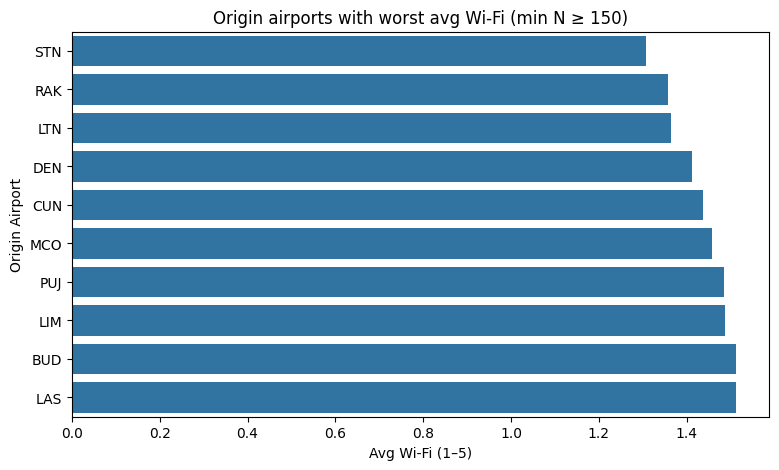

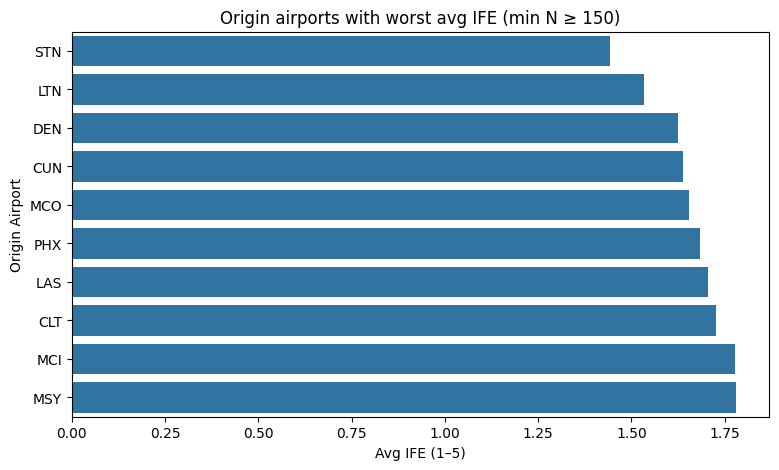

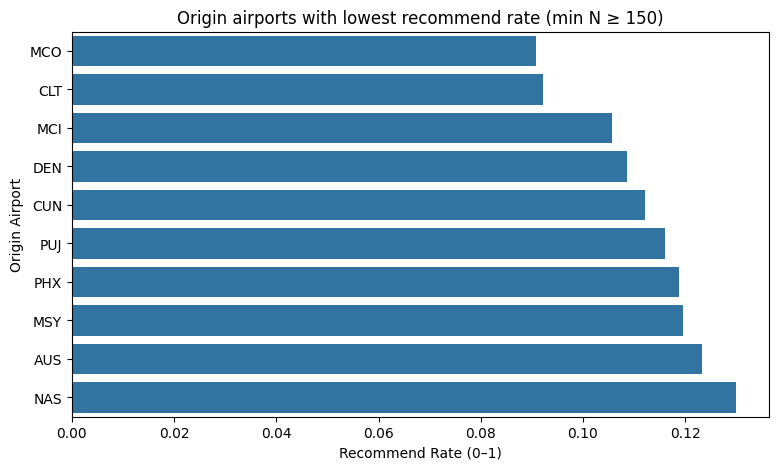

In [370]:
# Small airports can be noisy; set a minimum review count
MIN_N = 150

origin_metrics = (eda23.groupby("ORIGIN_AIRPORT")
                  .agg(n=("RECOMMENDED","size"),
                       wifi=("WIFI_AND_CONNECTIVITY","mean"),
                       ife=("INFLIGHT_ENTERTAINMENT","mean"),
                       rec_rate=("RECOMMENDED","mean"))
                  .dropna(subset=["wifi","ife"])
                  .query("n >= @MIN_N")
                  .sort_values("n", ascending=False))

# Worst Wi-Fi (top 10)
worst_wifi_o = origin_metrics.sort_values("wifi", ascending=True).head(10)

plt.figure(figsize=(9,5))
sns.barplot(y=worst_wifi_o.index, x=worst_wifi_o["wifi"])
plt.title("Origin airports with worst avg Wi-Fi (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg Wi-Fi (1–5)")
plt.ylabel("Origin Airport")
plt.show()

# Worst IFE (top 10)
worst_ife_o = origin_metrics.sort_values("ife", ascending=True).head(10)

plt.figure(figsize=(9,5))
sns.barplot(y=worst_ife_o.index, x=worst_ife_o["ife"])
plt.title("Origin airports with worst avg IFE (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg IFE (1–5)")
plt.ylabel("Origin Airport")
plt.show()

# Lowest recommendation rate (top 10)
lowest_rec_o = origin_metrics.sort_values("rec_rate", ascending=True).head(10)

plt.figure(figsize=(9,5))
sns.barplot(y=lowest_rec_o.index, x=lowest_rec_o["rec_rate"])
plt.title("Origin airports with lowest recommend rate (min N ≥ %d)" % MIN_N)
plt.xlabel("Recommend Rate (0–1)")
plt.ylabel("Origin Airport")
plt.show()


- **Wi-Fi**: Stansted (STN), Marrakech (RAK), and London Luton (LTN) ranked lowest, with average ratings barely above 1 on a 5-point scale.  
- **In-Flight Entertainment (IFE)**: STN and LTN again appear among the worst, along with Denver (DEN) and Cancun (CUN).  
- **Recommendation Rate**: Major hubs like Orlando (MCO), Charlotte (CLT), and Denver (DEN) are among the lowest-rated, with recommendation rates around 10–12%.  

**Takeaway**: Certain airports consistently underperform across multiple service dimensions (e.g., STN, DEN, CUN), suggesting broader issues with the travel experience originating from these hubs.

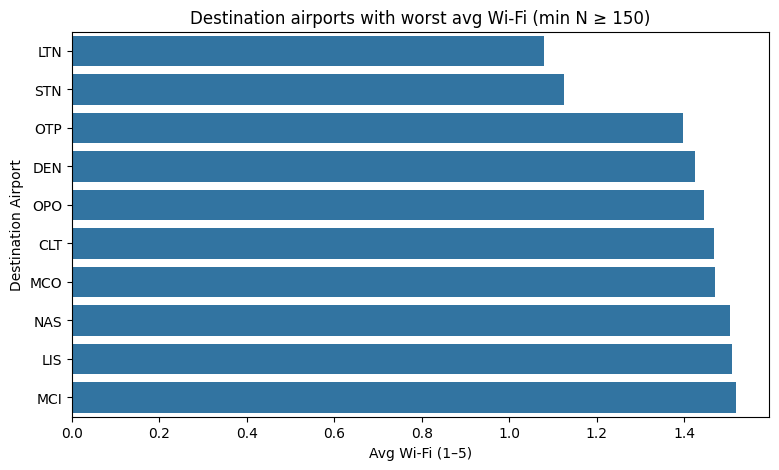

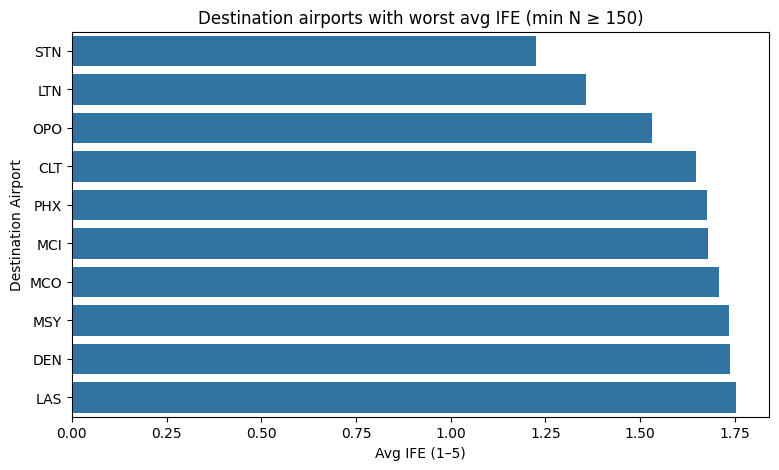

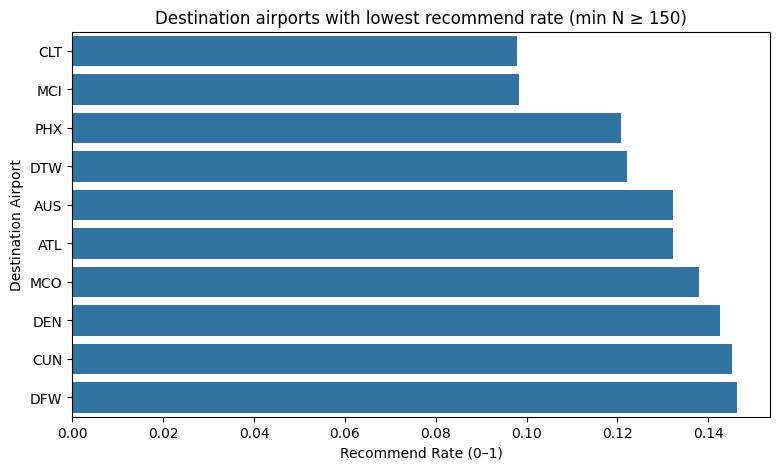

In [371]:
dest_metrics = (eda23.groupby("DEST_AIRPORT")
                .agg(n=("RECOMMENDED","size"),
                     wifi=("WIFI_AND_CONNECTIVITY","mean"),
                     ife=("INFLIGHT_ENTERTAINMENT","mean"),
                     rec_rate=("RECOMMENDED","mean"))
                .dropna(subset=["wifi","ife"])
                .query("n >= @MIN_N")
                .sort_values("n", ascending=False))

# Worst Wi-Fi (top 10)
worst_wifi_d = dest_metrics.sort_values("wifi", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_wifi_d.index, x=worst_wifi_d["wifi"])
plt.title("Destination airports with worst avg Wi-Fi (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg Wi-Fi (1–5)")
plt.ylabel("Destination Airport")
plt.show()

# Worst IFE (top 10)
worst_ife_d = dest_metrics.sort_values("ife", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_ife_d.index, x=worst_ife_d["ife"])
plt.title("Destination airports with worst avg IFE (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg IFE (1–5)")
plt.ylabel("Destination Airport")
plt.show()

# Lowest recommendation rate (top 10)
lowest_rec_d = dest_metrics.sort_values("rec_rate", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=lowest_rec_d.index, x=lowest_rec_d["rec_rate"])
plt.title("Destination airports with lowest recommend rate (min N ≥ %d)" % MIN_N)
plt.xlabel("Recommend Rate (0–1)")
plt.ylabel("Destination Airport")
plt.show()


### 2.6 Aircraft Experience (may add this)

We evaluated aircrafts with at least 150 reviews to reduce noise.  


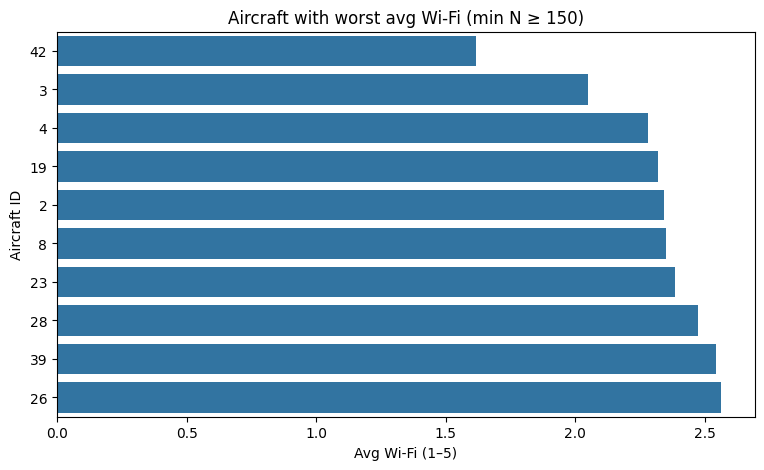

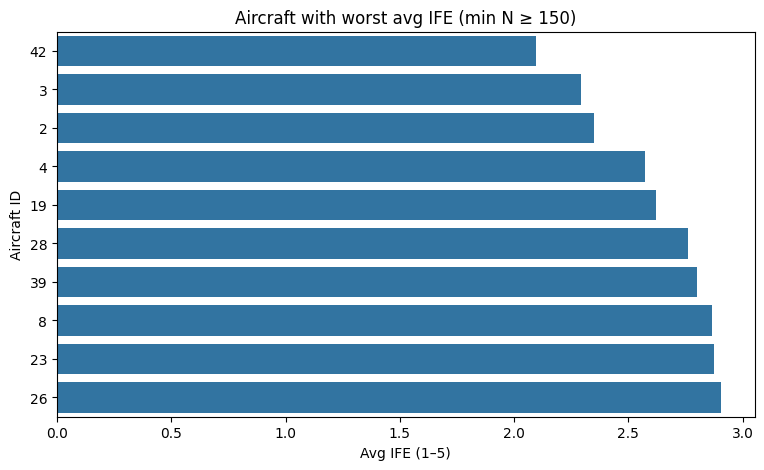

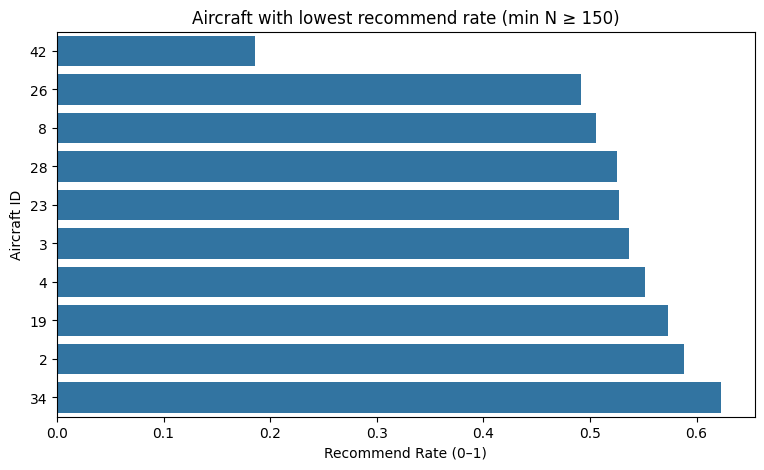

In [372]:
aircraft_metrics = (eda23.groupby("AIRCRAFT_ID")
                    .agg(n=("RECOMMENDED","size"),
                         wifi=("WIFI_AND_CONNECTIVITY","mean"),
                         ife=("INFLIGHT_ENTERTAINMENT","mean"),
                         rec_rate=("RECOMMENDED","mean"))
                    .dropna(subset=["wifi","ife"])
                    .query("n >= @MIN_N")
                    .sort_values("n", ascending=False))

# Worst Wi-Fi (top 10)
worst_wifi_ac = aircraft_metrics.sort_values("wifi", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_wifi_ac.index.astype(str), x=worst_wifi_ac["wifi"])
plt.title("Aircraft with worst avg Wi-Fi (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg Wi-Fi (1–5)")
plt.ylabel("Aircraft ID")
plt.show()

# Worst IFE (top 10)
worst_ife_ac = aircraft_metrics.sort_values("ife", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=worst_ife_ac.index.astype(str), x=worst_ife_ac["ife"])
plt.title("Aircraft with worst avg IFE (min N ≥ %d)" % MIN_N)
plt.xlabel("Avg IFE (1–5)")
plt.ylabel("Aircraft ID")
plt.show()

# Lowest recommendation rate (top 10)
lowest_rec_ac = aircraft_metrics.sort_values("rec_rate", ascending=True).head(10)
plt.figure(figsize=(9,5))
sns.barplot(y=lowest_rec_ac.index.astype(str), x=lowest_rec_ac["rec_rate"])
plt.title("Aircraft with lowest recommend rate (min N ≥ %d)" % MIN_N)
plt.xlabel("Recommend Rate (0–1)")
plt.ylabel("Aircraft ID")
plt.show()


**Part 2: Summary**:  
Passenger satisfaction is shaped most strongly by the core travel experience—ground service, cabin staff, food, and seat comfort—while amenities like Wi-Fi and in-flight entertainment play a smaller role. High-volume U.S. carriers struggle with recommendation rates, whereas international and premium airlines such as China Southern, Garuda Indonesia, Qatar, and Singapore Airlines set the standard for positive experiences. Satisfaction consistently rises with cabin class, and solo leisure travelers tend to be more positive than families, who report the lowest value and recommendation levels. Negative sentiment is most concentrated among major U.S. airlines and repeatedly linked to specific airports, notably STN, LTN, DEN, MCO, and CLT. Together, these patterns suggest that improvements in core services, targeted attention to Economy and family segments, and focused interventions at underperforming airports would deliver the greatest business impact.


## **Part 3: Target-specific EDA: 
3a. RECOMMENDED.

3a.1 Normalize target & quick class balance

Counts:
 RECOMMENDED
Not Recommend    82925
Recommend        38896
Name: count, dtype: int64 

Percentages (%):
 RECOMMENDED
Not Recommend    68.07
Recommend        31.93
Name: count, dtype: float64


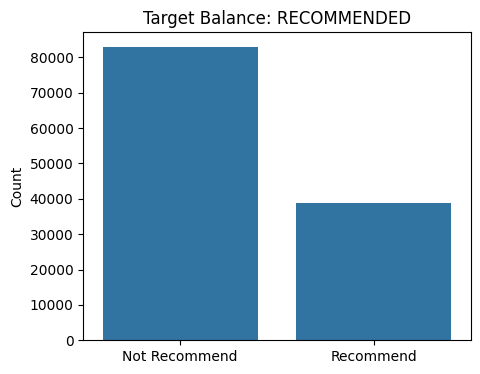

In [373]:
df3 = pdf_sample.copy()
df3["RECOMMENDED"] = (
    df3["RECOMMENDED"].astype(str).str.lower().isin(["true","1","yes"])
).astype(int)

# Class balance table
bal = df3["RECOMMENDED"].value_counts().rename(index={0:"Not Recommend",1:"Recommend"})
print("Counts:\n", bal, "\n")
print("Percentages (%):\n", (bal / bal.sum() * 100).round(2))

# Bar chart
plt.figure(figsize=(5,4))
sns.countplot(x=df3["RECOMMENDED"].map({0:"Not Recommend",1:"Recommend"}))
plt.title("Target Balance: RECOMMENDED")
plt.xlabel("")
plt.ylabel("Count")
plt.show()


The target variable is moderately imbalanced, with about **68% of passengers not recommending** their airline experience and only **32% recommending** it. This indicates that overall sentiment leans negative, and any model trained on this data must account for the imbalance. A naive classifier that always predicts “Not Recommend” would already achieve ~68% accuracy, so future modeling should emphasize balanced metrics (e.g., AUC, F1, precision-recall) and may benefit from resampling or class weighting strategies.


3a.2 Service ratings vs RECOMMENDED (mean difference)

In [374]:
# Compute mean rating by class for each numeric feature
means = (df3
         .groupby("RECOMMENDED")[NUMERIC_COLS]
         .mean()
         .T
         .rename(index=str))
means.columns = ["Not Recommend","Recommend"]
means_sorted = means.sort_values("Recommend", ascending=False)
means_sorted.round(3)


,Not Recommend,Recommend
CABIN_STAFF_SERVICE,1.980,4.451
VALUE_FOR_MONEY,1.457,4.362
GROUND_SERVICE,1.467,4.162
AVERAGE_RATING,1.613,4.125
SEAT_COMFORT,1.795,4.035
FOOD_AND_BEVERAGES,1.663,3.942
INFLIGHT_ENTERTAINMENT,1.752,3.794
WIFI_AND_CONNECTIVITY,1.397,3.566


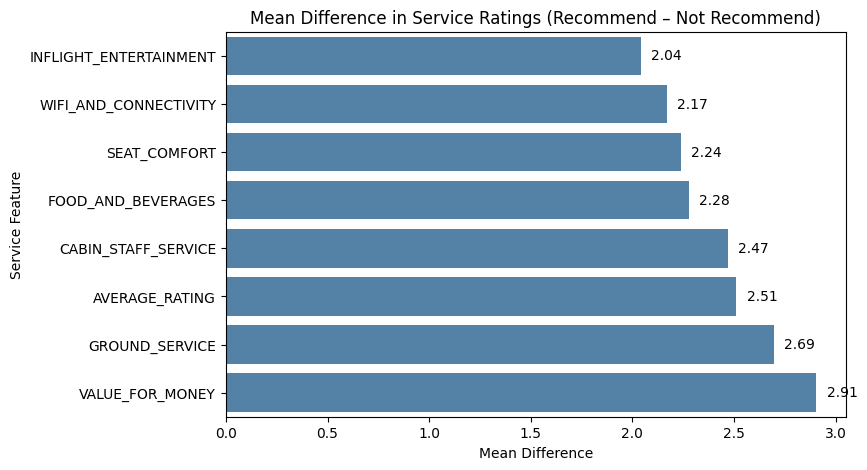

In [375]:
# Suggested to add to 3a.2

# Reason:
# Plotting the mean differences helps quickly visualize which service features
# most strongly separate recommenders from non-recommenders. 
# Unlike the table, this chart makes the relative ranking and magnitude 
# of differences immediately clear for interpretation and later comparison with model feature importance.

# Compute mean differences
mean_diff = (means["Recommend"] - means["Not Recommend"]).sort_values(ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=mean_diff.values, y=mean_diff.index, color="steelblue")
plt.title("Mean Difference in Service Ratings (Recommend – Not Recommend)")
plt.xlabel("Mean Difference")
plt.ylabel("Service Feature")

# Add value labels
for i, v in enumerate(mean_diff.values):
    plt.text(v + 0.05, i, f"{v:.2f}", va='center')

plt.show()


The mean difference plot shows that passengers who recommend their airline experience give consistently higher ratings across all service dimensions. The strongest gaps appear in **Value for Money (+2.91)**, **Ground Service (+2.69)**, and **Average Rating (+2.51)**, followed closely by **Cabin Staff Service (+2.47)**. Core experience factors (value, ground, staff, seat comfort, and food) dominate, while **Wi-Fi (+2.17)** and **In-flight Entertainment (+2.04)** show smaller but still meaningful differences. This reinforces that recommendation is driven most by the fundamentals of service and perceived value, with amenities playing a secondary role. The consistent positive separation across every feature also suggests these variables are highly predictive for modeling.

3a.3 Distributions of key ratings by class (box/violin)

In [376]:
key_cols = ["SEAT_COMFORT","CABIN_STAFF_SERVICE","FOOD_AND_BEVERAGES",
            "INFLIGHT_ENTERTAINMENT","WIFI_AND_CONNECTIVITY","AVERAGE_RATING"]

melted = df3[["RECOMMENDED"] + key_cols].melt(id_vars="RECOMMENDED",
                                              var_name="feature", value_name="score")
melted["class"] = melted["RECOMMENDED"].map({0:"Not Recommend",1:"Recommend"})

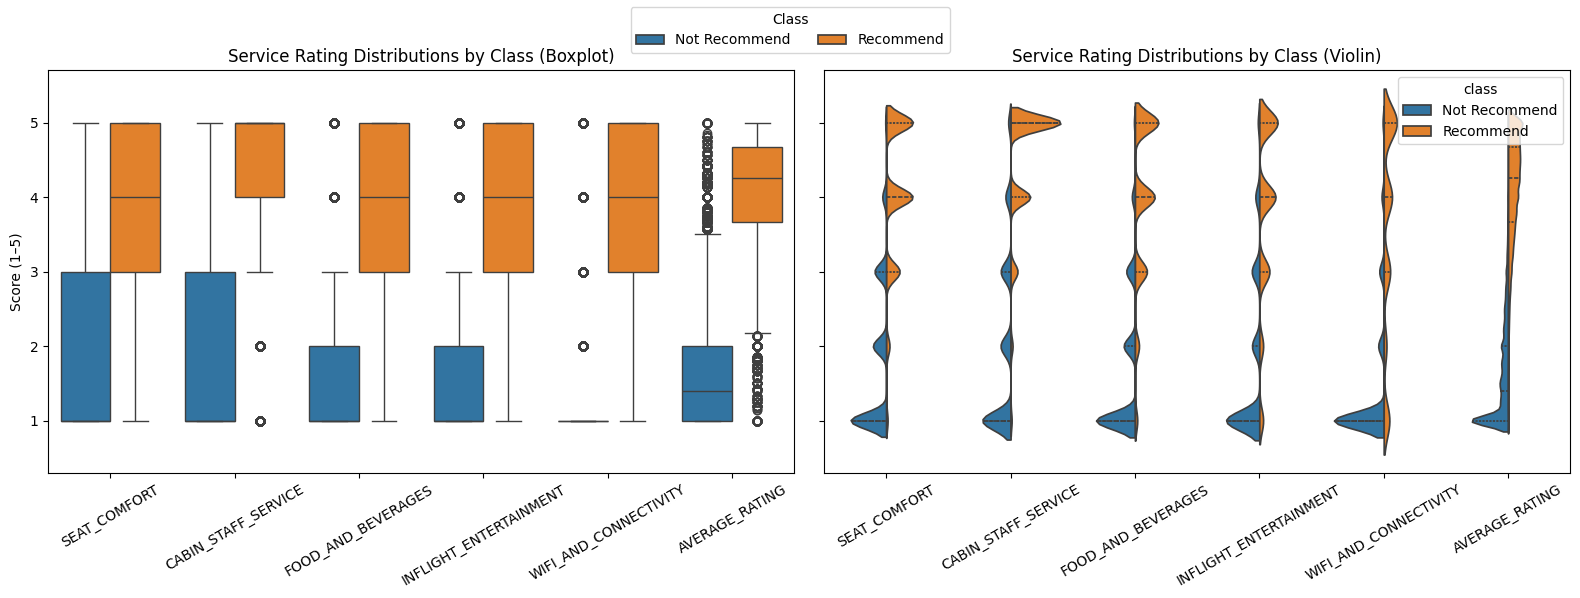

In [377]:
# Reason:
# Boxplots are good for showing summary statistics (median, quartiles, spread).
# Violin plots add the full distribution shape, revealing how scores cluster 
# (e.g., non-recommenders spiking at 1, recommenders peaking at 4–5).
# Putting them side by side makes it easy to see both perspectives at once.

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Boxplot (summary view)
sns.boxplot(data=melted, x="feature", y="score", hue="class", ax=axes[0])
axes[0].set_title("Service Rating Distributions by Class (Boxplot)")
axes[0].set_xlabel("")
axes[0].set_ylabel("Score (1–5)")
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend_.remove()  # remove duplicate legend (we'll add a shared one)

# Violin plot (distribution view)
sns.violinplot(data=melted, x="feature", y="score", hue="class",
               split=True, inner="quart", ax=axes[1])
axes[1].set_title("Service Rating Distributions by Class (Violin)")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', rotation=30)

# Add one shared legend above both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Class", loc="upper center", ncol=2)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



The side-by-side plots provide complementary perspectives on service ratings by recommendation class. The **boxplots** (left) summarize central tendency and spread, showing that non-recommenders cluster near the lowest scores (1–2) while recommenders concentrate around 4–5 across all service dimensions. The **violin plots** (right) reveal the underlying distribution shapes, with clear spikes at 1 for non-recommenders and strong peaks at 4–5 for recommenders, emphasizing how polarized the two groups are. Together, these views show not only the average separation but also how tightly ratings are clustered, reinforcing that positive recommendations are strongly tied to consistently high service ratings, especially for staff, value, and comfort.

3a.4 Segment differences in recommend rate (seat type, traveller type)

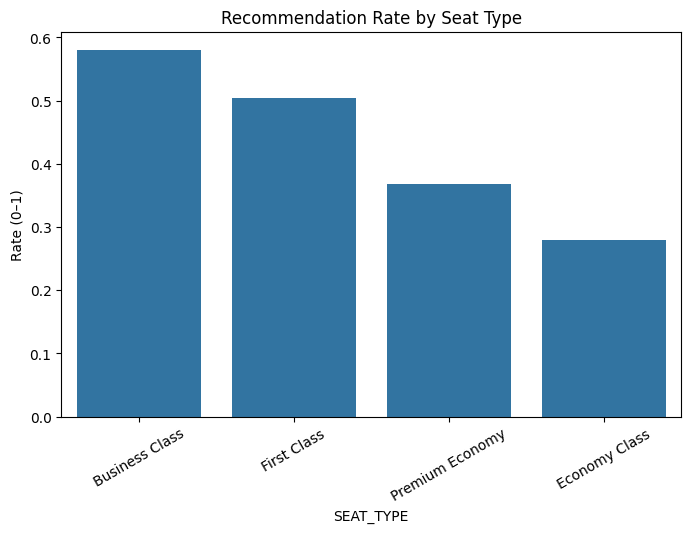

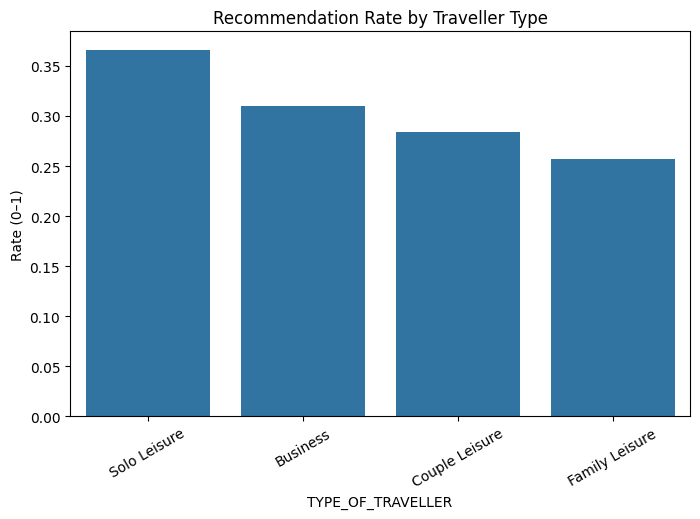

In [378]:
# Seat type
seat_rate = (df3.groupby("SEAT_TYPE")["RECOMMENDED"].mean()
             .sort_values(ascending=False))
plt.figure(figsize=(8,5))
sns.barplot(x=seat_rate.index, y=seat_rate.values)
plt.title("Recommendation Rate by Seat Type")
plt.ylabel("Rate (0–1)")
plt.xticks(rotation=30)
plt.show()

# Traveller type
trav_rate = (df3.groupby("TYPE_OF_TRAVELLER")["RECOMMENDED"].mean()
             .sort_values(ascending=False))
plt.figure(figsize=(8,5))
sns.barplot(x=trav_rate.index, y=trav_rate.values)
plt.title("Recommendation Rate by Traveller Type")
plt.ylabel("Rate (0–1)")
plt.xticks(rotation=30)
plt.show()


Segment analysis confirms that recommendation likelihood varies strongly by both cabin and traveller type. Passengers in **Business (≈58%)** and **First Class (≈51%)** are far more likely to recommend compared to **Premium Economy (≈37%)** and especially **Economy (≈28%)**, underscoring the challenge of driving loyalty in the lowest cabin. Traveller segments show a similar divide: **Solo Leisure (≈37%)** travelers are the most positive, while **Family Leisure (≈26%)** are the least likely to recommend, with Business and Couple Leisure falling in between. Together, these findings highlight that recommendation is not only driven by service quality but also by who the traveler is and what cabin they fly, making Economy and Family Leisure the priority segments for improvement.


3a.5 Airline benchmarking (multi-airline scope) — top N by volume

/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3582163080.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_airlines.index, x=top_airlines.values, palette="Blues_r", ax=axes[0])
/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3582163080.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bottom_airlines.index, x=bottom_airlines.values, palette="Reds_r", ax=axes[1])


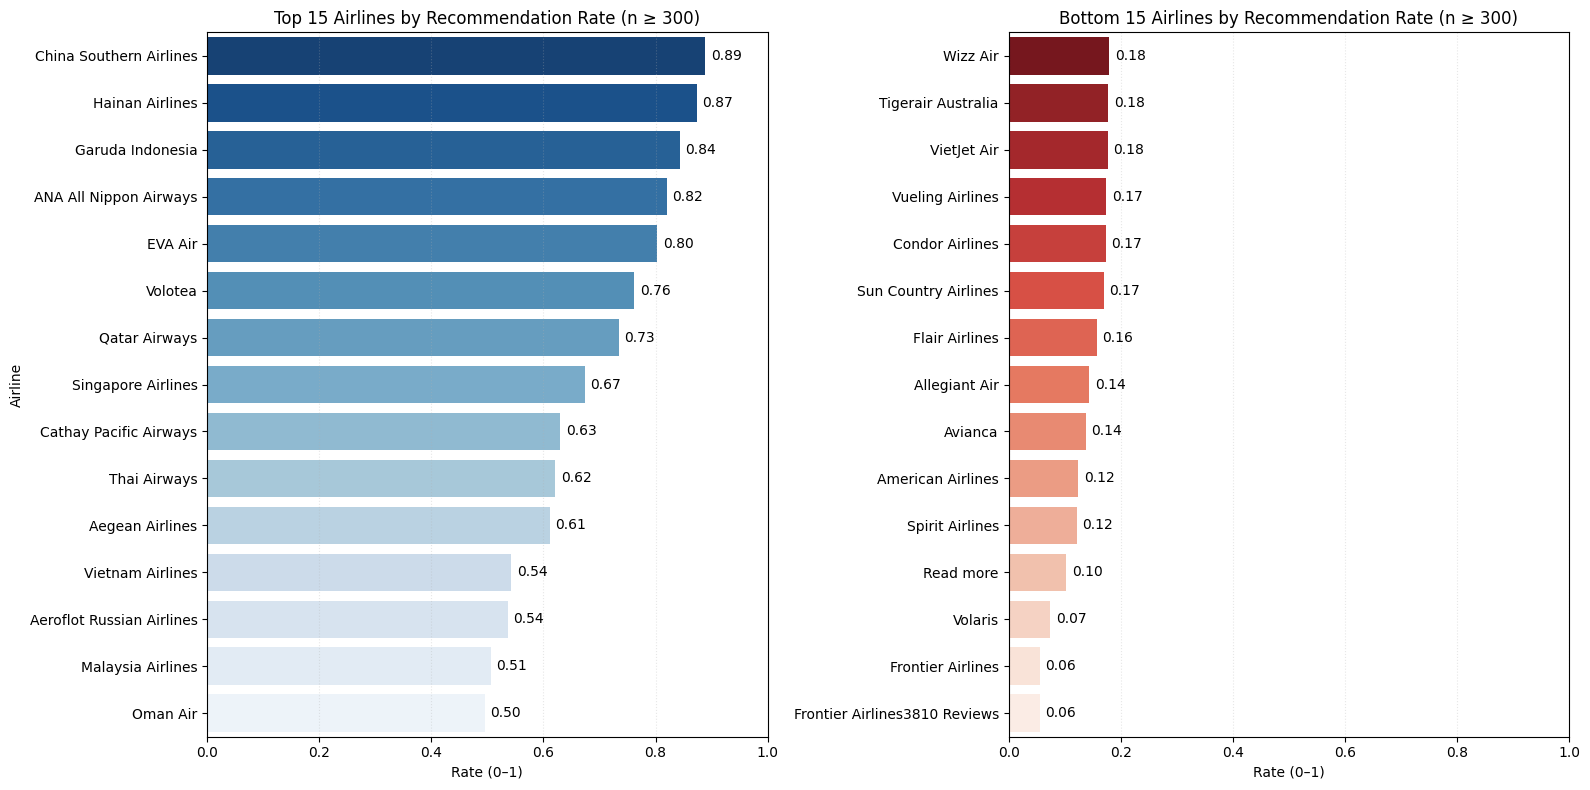

In [379]:
# Focus on airlines with enough reviews to be stable
min_n = 300
air_counts = df3["AIRLINE"].value_counts()
big_airlines = air_counts[air_counts >= min_n].index

air_rate = (df3[df3["AIRLINE"].isin(big_airlines)]
            .groupby("AIRLINE")["RECOMMENDED"].mean()
            .sort_values(ascending=False))

# --- Top & Bottom Airlines by Recommendation Rate (n ≥ min_n) ---

top_n = 15
top_airlines = air_rate.head(top_n)
bottom_airlines = air_rate.tail(top_n)

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# Top airlines (blue gradient)
sns.barplot(y=top_airlines.index, x=top_airlines.values, palette="Blues_r", ax=axes[0])
axes[0].set_title(f"Top {top_n} Airlines by Recommendation Rate (n ≥ {min_n})")
axes[0].set_xlabel("Rate (0–1)")
axes[0].set_ylabel("Airline")
for i, v in enumerate(top_airlines.values):
    axes[0].text(v + 0.01, i, f"{v:.2f}", va="center")

# Bottom airlines (red gradient)
sns.barplot(y=bottom_airlines.index, x=bottom_airlines.values, palette="Reds_r", ax=axes[1])
axes[1].set_title(f"Bottom {top_n} Airlines by Recommendation Rate (n ≥ {min_n})")
axes[1].set_xlabel("Rate (0–1)")
axes[1].set_ylabel("")
for i, v in enumerate(bottom_airlines.values):
    axes[1].text(v + 0.01, i, f"{v:.2f}", va="center")

# Shared formatting
for ax in axes:
    ax.set_xlim(0, 1)  # recommendation rate is bounded 0–1
    ax.grid(axis="x", linestyle=":", alpha=0.3)

plt.tight_layout()
plt.show()




Top airlines like China Southern, Hainan, and Garuda Indonesia achieve 80%+ recommend rates, while bottom carriers such as Wizz Air, Tigerair, and Frontier struggle below 20%. This highlights strong gaps in customer satisfaction across airlines.

3a.6 Categorical association check (chi-square)

In [380]:
# Chi-square tests show all tested categorical variables 
# (seat type, traveller type, rating band, airline) are 
# highly associated with RECOMMENDED (p ≈ 0). 
# This provides statistical confirmation of earlier visual insights 
# and flags them as important categorical predictors to consider 
# in modeling.

from scipy.stats import chi2_contingency

def chi2_summary(df, cat_col, target="RECOMMENDED"):
    ct = pd.crosstab(df[cat_col], df[target])
    chi2, p, dof, _ = chi2_contingency(ct)
    return pd.DataFrame({
        "category":[cat_col],
        "chi2":[chi2],
        "dof":[dof],
        "p_value":[p],
        "min_expected":[_.min()]
    })

cats_to_test = ["SEAT_TYPE","TYPE_OF_TRAVELLER","RATING_BAND","AIRLINE"]
out = pd.concat([chi2_summary(df3, c) for c in cats_to_test], ignore_index=True)
out.sort_values("p_value")


,category,chi2,dof,p_value,min_expected
0,SEAT_TYPE,5336.156074,3,0.000000e+00,659.041646
2,RATING_BAND,80137.489439,3,0.000000e+00,4.470034
3,AIRLINE,21907.777092,548,0.000000e+00,0.319288
1,TYPE_OF_TRAVELLER,1072.256320,3,3.801827e-232,5401.417236


/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3986495381.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="chi2", y="category", data=out.sort_values("chi2", ascending=False), palette="Blues_r")


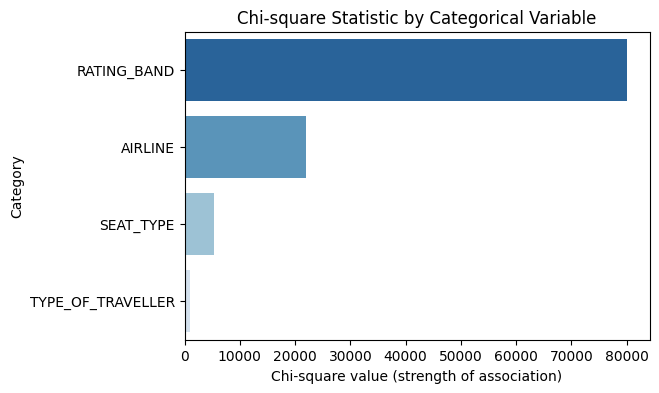

/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/3986495381.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cramers_v", y="category", data=cramers_df, palette="Greens_r")


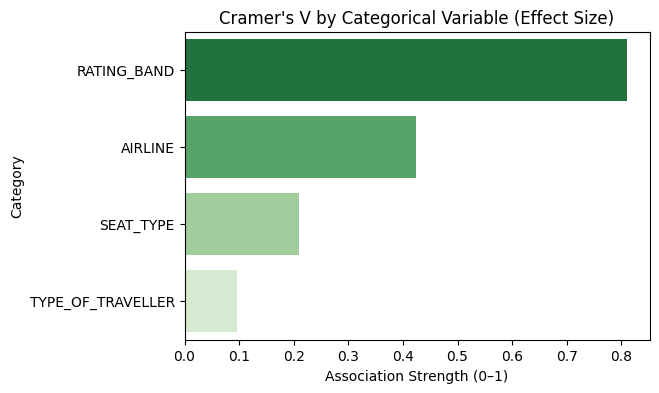

In [381]:
# Chi-square and Cramer's V (testable)
from scipy.stats import chi2_contingency
def chi2_summary(df, cat_col, target="RECOMMENDED"):
    ct = pd.crosstab(df[cat_col], df[target])
    chi2, p, dof, expected = chi2_contingency(ct)
    return pd.DataFrame({
        "category":[cat_col],
        "chi2":[chi2],
        "dof":[dof],
        "p_value":[p],
        "min_expected":[expected.min()]
    })
cats_to_test = ["SEAT_TYPE","TYPE_OF_TRAVELLER","RATING_BAND","AIRLINE"]
out = pd.concat([chi2_summary(df3, c) for c in cats_to_test], ignore_index=True)
plt.figure(figsize=(6,4))
sns.barplot(x="chi2", y="category", data=out.sort_values("chi2", ascending=False), palette="Blues_r")
plt.title("Chi-square Statistic by Categorical Variable")
plt.xlabel("Chi-square value (strength of association)")
plt.ylabel("Category")
plt.show()

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r,k)-1)))
cramers = []
for c in cats_to_test:
    ct = pd.crosstab(df3[c], df3["RECOMMENDED"])
    cramers.append({"category": c, "cramers_v": cramers_v(ct)})
cramers_df = pd.DataFrame(cramers).sort_values("cramers_v", ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x="cramers_v", y="category", data=cramers_df, palette="Greens_r")
plt.title("Cramer's V by Categorical Variable (Effect Size)")
plt.xlabel("Association Strength (0–1)")
plt.ylabel("Category")
plt.show()

All tested categorical variables show significant association with recommendation (p < 0.001). The strongest driver is **Rating Band**, followed by **Airline**, then **Seat Type** and **Traveller Type**. Effect sizes confirm that rating patterns dominate loyalty signals.

3a.7 Is AVERAGE_RATING too predictive? Leakage sanity check

In [382]:
# Correlation (point-biserial via Pearson with {0,1})
corr_avg = df3[["AVERAGE_RATING","RECOMMENDED"]].corr().iloc[0,1]
print(f"Correlation(Average Rating, RECOMMENDED) = {corr_avg:.3f}")

# If this is extremely high (e.g., >0.7), consider training a model both with and without AVERAGE_RATING
# to verify it doesn't trivially leak the decision rule behind RECOMMENDED.


Correlation(Average Rating, RECOMMENDED) = 0.857


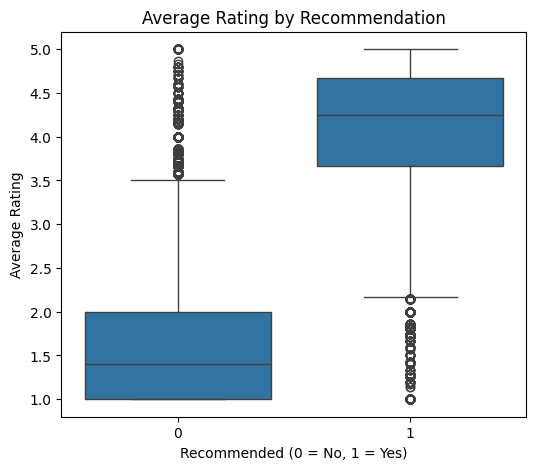

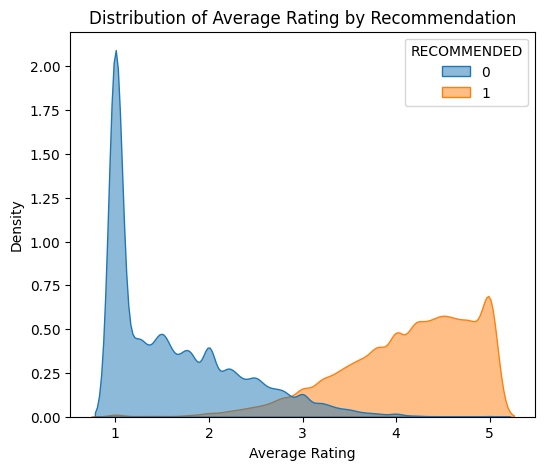

In [383]:
# Visualize Average Rating vs Recommended
plt.figure(figsize=(6,5))
sns.boxplot(x="RECOMMENDED", y="AVERAGE_RATING", data=df3)
plt.title("Average Rating by Recommendation")
plt.xlabel("Recommended (0 = No, 1 = Yes)")
plt.ylabel("Average Rating")
plt.show()

# Optional: density plot for clearer separation
plt.figure(figsize=(6,5))
sns.kdeplot(data=df3, x="AVERAGE_RATING", hue="RECOMMENDED", fill=True, common_norm=False, alpha=0.5)
plt.title("Distribution of Average Rating by Recommendation")
plt.xlabel("Average Rating")
plt.show()


Correlation between **Average Rating** and **Recommendation** is 0.857, suggesting near-perfect predictive power. This indicates potential label leakage—models must be tested with and without this variable to avoid inflated performance.

While the recommendation analysis highlights overall loyalty patterns, part 3b focuses on **VALUE_FOR_MONEY** as a complementary lens into passenger satisfaction, helping explain why some groups are more likely to recommend than others.

## Part 3b: Target-Specific EDA for VALUE_FOR_MONEY.

3b.1 Distribution of VALUE_FOR_MONEY

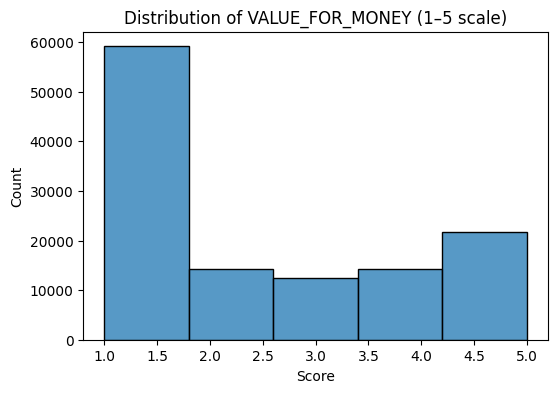

count    121806.000000
mean          2.384505
std           1.584366
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: VALUE_FOR_MONEY, dtype: float64


In [384]:
plt.figure(figsize=(6,4))
sns.histplot(df3["VALUE_FOR_MONEY"], bins=5, kde=False)
plt.title("Distribution of VALUE_FOR_MONEY (1–5 scale)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

print(df3["VALUE_FOR_MONEY"].describe())


The ratings are polarized, with most passengers giving 1 (poor value) and a smaller but notable group giving 5 (excellent value). The median is 2, mean 2.38, showing overall dissatisfaction, though a significant minority rate airlines very positively.

3b.2 Correlation with other service ratings

VALUE_FOR_MONEY           1.000000
AVERAGE_RATING            0.914047
GROUND_SERVICE            0.811608
SEAT_COMFORT              0.764219
FOOD_AND_BEVERAGES        0.760149
CABIN_STAFF_SERVICE       0.747016
WIFI_AND_CONNECTIVITY     0.687285
INFLIGHT_ENTERTAINMENT    0.683865
Name: VALUE_FOR_MONEY, dtype: float64


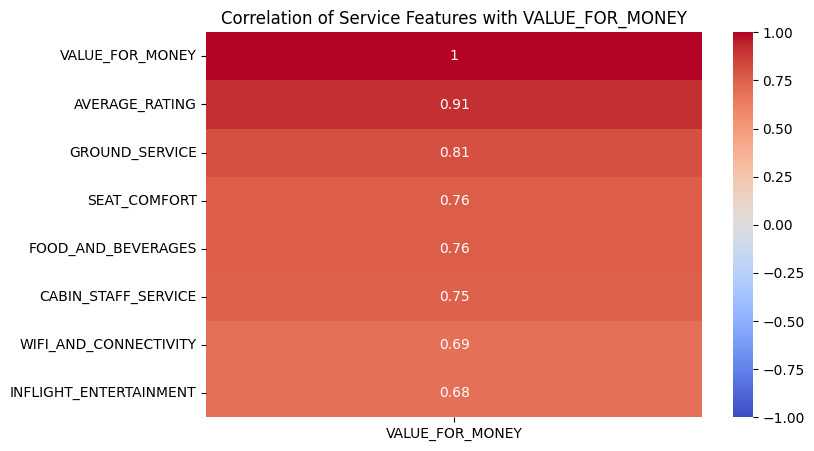

In [385]:
# Correlation matrix with VALUE_FOR_MONEY
corrs = df3[NUMERIC_COLS].corr()["VALUE_FOR_MONEY"].sort_values(ascending=False)
print(corrs)

# Heatmap
plt.figure(figsize=(8,5))
sns.heatmap(df3[NUMERIC_COLS].corr()[["VALUE_FOR_MONEY"]].sort_values(by="VALUE_FOR_MONEY", ascending=False),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation of Service Features with VALUE_FOR_MONEY")
plt.show()


**Value for Money** is most strongly tied to **Average Rating (0.91)**, confirming overlap with overall satisfaction. Key service drivers include **Ground Service (0.81)**, **Seat Comfort (0.76)**, and **Food & Beverages (0.76)**, while **WiFi** and **Entertainment** show weaker but still positive links (\~0.68–0.69). This suggests that passengers’ value perception is shaped by both overall rating and specific service touchpoints, especially ground and comfort factors.


3b.3 Segment differences in VALUE_FOR_MONEY

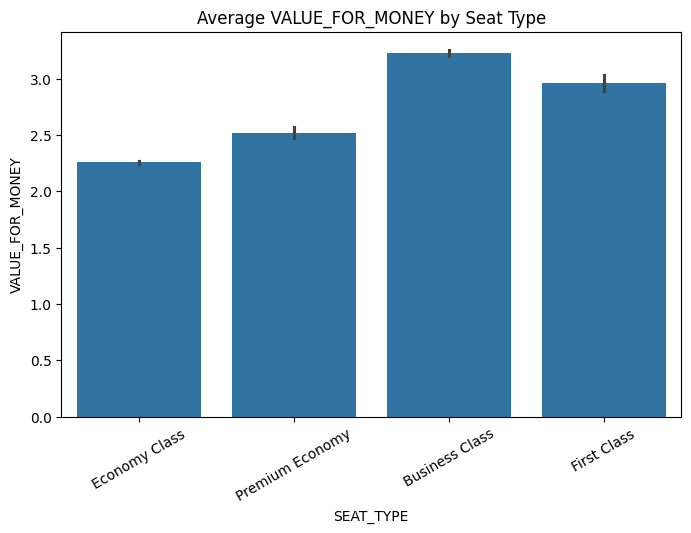

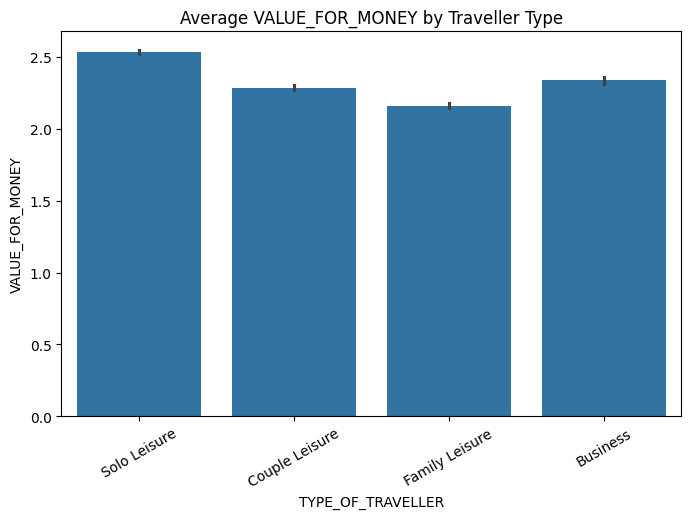

In [386]:
# By Seat Type
plt.figure(figsize=(8,5))
sns.barplot(x="SEAT_TYPE", y="VALUE_FOR_MONEY", data=df3,
            order=["Economy Class","Premium Economy","Business Class","First Class"])
plt.title("Average VALUE_FOR_MONEY by Seat Type")
plt.xticks(rotation=30)
plt.show()

# By Traveller Type
plt.figure(figsize=(8,5))
sns.barplot(x="TYPE_OF_TRAVELLER", y="VALUE_FOR_MONEY", data=df3,
            order=["Solo Leisure","Couple Leisure","Family Leisure","Business"])
plt.title("Average VALUE_FOR_MONEY by Traveller Type")
plt.xticks(rotation=30)
plt.show()


By **Seat Type**, Business Class (3.2) and First Class (2.9) receive the highest value-for-money scores, while Economy passengers (2.3) rate the lowest, highlighting a clear gap between premium and standard cabins. For **Traveller Type**, Solo Leisure (2.5) travelers perceive the most value, whereas Family Leisure (2.2) report the least, suggesting that group/family experiences may feel less rewarding relative to cost.

3b.4 Airline benchmarking (value-for-money scores)

/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/1800961421.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_air.index, x=top_air.values, palette="Blues_r", ax=axes[0])
/var/folders/kb/s78ygzfd12g004g1j4gf1j0m0000gn/T/ipykernel_99011/1800961421.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=bot_air.index, x=bot_air.values, palette="Reds", ax=axes[1])


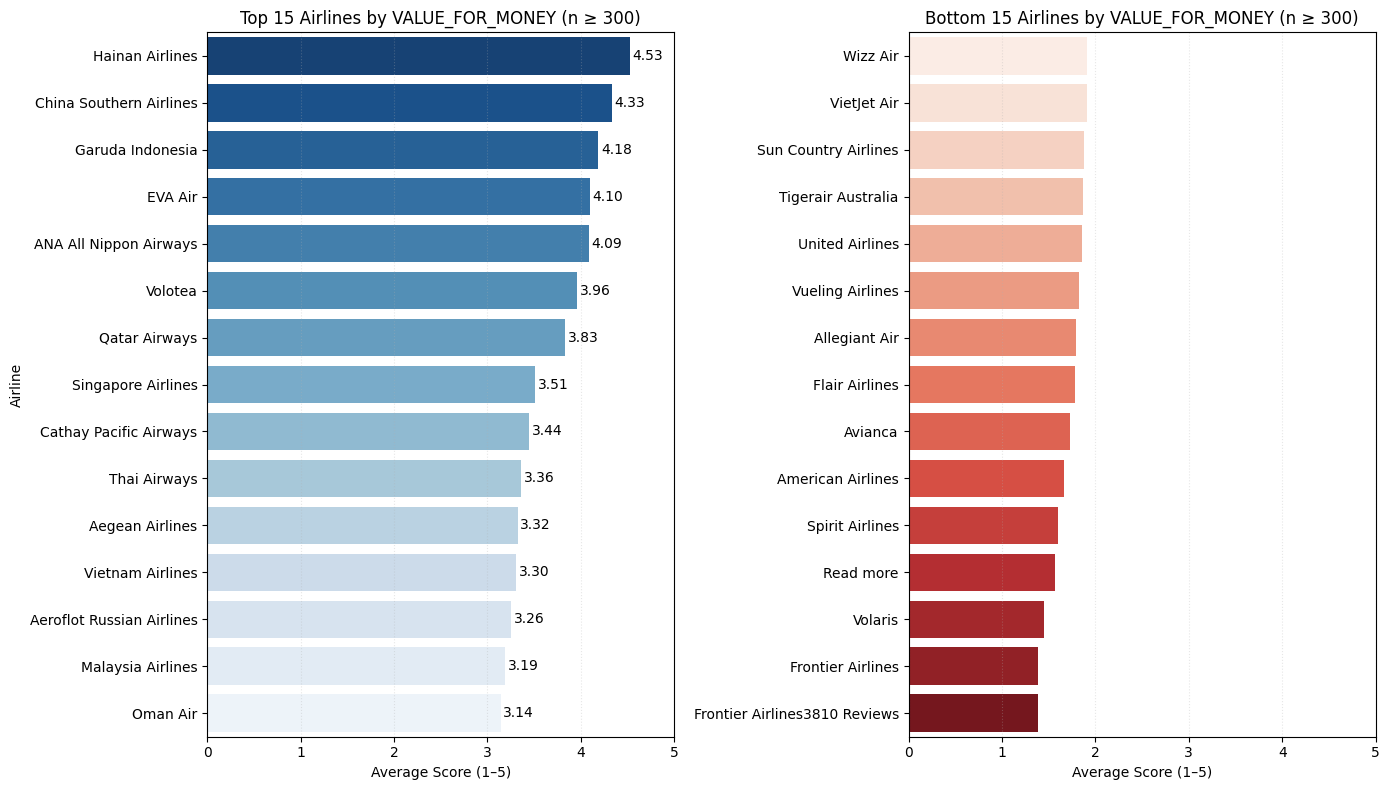

In [387]:
# Focus on airlines with enough reviews
min_n = 300
air_counts = df3["AIRLINE"].value_counts()
big_airlines = air_counts[air_counts >= min_n].index

air_vfm = (df3[df3["AIRLINE"].isin(big_airlines)]
           .groupby("AIRLINE")["VALUE_FOR_MONEY"].mean()
           .sort_values(ascending=False))

# Suggested code for less clustered graph but only some airlines

# Top & Bottom 15 VALUE_FOR_MONEY by Airline (n ≥ 300)

min_n = 300
air_counts = df3["AIRLINE"].value_counts()
big_airlines = air_counts[air_counts >= min_n].index

air_vfm = (df3[df3["AIRLINE"].isin(big_airlines)]
           .groupby("AIRLINE")["VALUE_FOR_MONEY"].mean()
           .sort_values(ascending=False))

top_n = 15
top_air = air_vfm.head(top_n)
bot_air = air_vfm.tail(top_n)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=True)

# Top performers (blue gradient)
sns.barplot(y=top_air.index, x=top_air.values, palette="Blues_r", ax=axes[0])
axes[0].set_title(f"Top {top_n} Airlines by VALUE_FOR_MONEY (n ≥ {min_n})")
axes[0].set_xlabel("Average Score (1–5)")
axes[0].set_ylabel("Airline")
for i, v in enumerate(top_air.values):
    axes[0].text(v + 0.03, i, f"{v:.2f}", va="center")

# Bottom performers (red gradient)
sns.barplot(y=bot_air.index, x=bot_air.values, palette="Reds", ax=axes[1])
axes[1].set_title(f"Bottom {top_n} Airlines by VALUE_FOR_MONEY (n ≥ {min_n})")
axes[1].set_xlabel("Average Score (1–5)")
axes[1].set_ylabel("")

# Common formatting
for ax in axes:
    ax.set_xlim(0, 5)  # VALUE_FOR_MONEY is on a 1–5 scale; keep room for labels
    ax.grid(axis="x", linestyle=":", alpha=0.3)

plt.tight_layout()
plt.show()





3b.5 Service rating distributions vs VALUE_FOR_MONEY

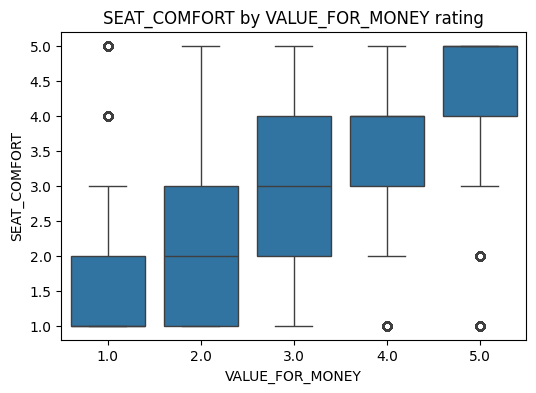

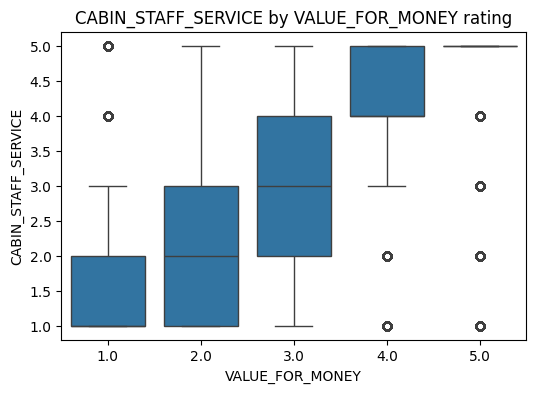

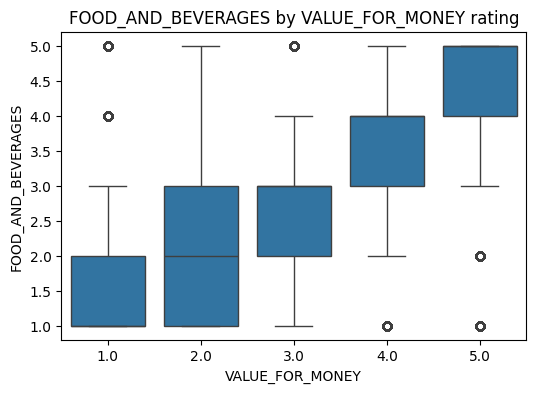

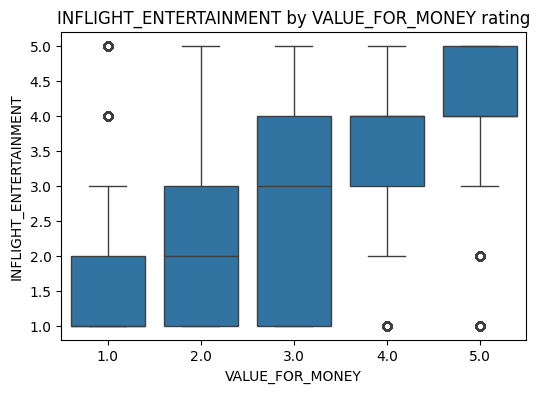

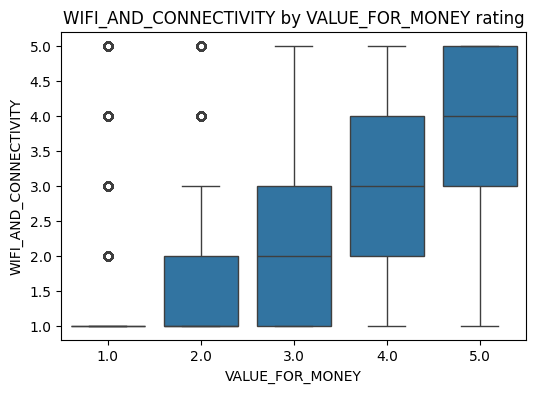

In [388]:
key_cols = ["SEAT_COMFORT","CABIN_STAFF_SERVICE","FOOD_AND_BEVERAGES",
            "INFLIGHT_ENTERTAINMENT","WIFI_AND_CONNECTIVITY"]

for col in key_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="VALUE_FOR_MONEY", y=col, data=df3)
    plt.title(f"{col} by VALUE_FOR_MONEY rating")
    plt.show()


Passengers who report higher VALUE_FOR_MONEY also rate every service higher—the distributions shift upward almost monotonically from VFM=1→5. The clearest lifts are in Seat Comfort, Cabin Staff, and Food & Beverages; Wi-Fi and IFE improve too but show more overlap and spread, indicating weaker, less consistent influence on perceived value. Net: value perceptions are driven mainly by core service execution, with amenities as secondary amplifiers.

## **Part 4: Modeling Prep**

4.1 Handle Missing Values

In [389]:
# # Strategy:
# # - Wi-Fi, IFE, Food: impute with 0 ("not available") or median
# # - Service ratings: median
# # - Drop rows with missing target (if any)

# from sklearn.impute import SimpleImputer

# # Check missing first
# df_missing = df3[NUMERIC_COLS + [TARGET_COL, TARGET_REG]].isnull().sum()
# print(df_missing)

# # Example imputation: median for ratings
# imputer = SimpleImputer(strategy="median")
# df3[NUMERIC_COLS] = imputer.fit_transform(df3[NUMERIC_COLS])


4.2 Encode Categorical Variables

In [390]:
# from sklearn.preprocessing import OneHotEncoder

# cat_cols = ["SEAT_TYPE", "TYPE_OF_TRAVELLER", "AIRLINE", "RATING_BAND"]
# encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# encoded = encoder.fit_transform(df3[cat_cols])
# encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))

# df_model = pd.concat([df3.drop(columns=cat_cols), encoded_df], axis=1)
# print(df_model.shape)


In [391]:
df_model

,SEAT_COMFORT,CABIN_STAFF_SERVICE,FOOD_AND_BEVERAGES,INFLIGHT_ENTERTAINMENT,GROUND_SERVICE,WIFI_AND_CONNECTIVITY,VALUE_FOR_MONEY,AVERAGE_RATING,RECOMMENDED,SEAT_TYPE_Business Class,...,AIRLINE_euroAtlantic Airways,AIRLINE_fastjet,AIRLINE_flyadeal,AIRLINE_flybe,AIRLINE_flybondi,AIRLINE_flydubai,RATING_BAND_Unknown,RATING_BAND_bad,RATING_BAND_good,RATING_BAND_medium
0,-1.072648,-1.190272,-1.076989,-1.106061,-0.789071,1.0,-0.873879,1.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.072648,-1.190272,-1.076989,-0.243694,-0.789071,1.0,-0.873879,1.14,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.366108,-0.542456,-0.304675,0.618674,-0.789071,NaN,-0.242672,2.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.366108,0.105361,-0.304675,-0.243694,-0.789071,NaN,-0.242672,2.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.072648,-1.190272,-0.304675,-0.243694,-0.789071,NaN,-0.873879,1.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121816,-1.072648,-1.190272,-1.076989,-0.243694,-0.789071,1.0,-0.873879,1.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
121817,0.340432,0.105361,-1.076989,-0.243694,-0.789071,NaN,-0.873879,1.80,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
121818,1.753512,1.400994,1.239952,2.343408,0.489269,NaN,1.650948,4.50,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
121819,1.046972,1.400994,1.239952,-1.106061,1.128439,NaN,1.019741,3.67,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


4.3 Scale Numeric Features

In [392]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# df_model[NUMERIC_COLS] = scaler.fit_transform(df_model[NUMERIC_COLS])


4.4 Check Multicollinearity

In [393]:
# # Quick correlation heatmap to check redundancy
# plt.figure(figsize=(10,8))
# sns.heatmap(df_model[NUMERIC_COLS].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
# plt.title("Correlation Between Numeric Features")
# plt.show()


4.5 Define Features and Targets

In [394]:
# # Only drop columns that exist in df_model
# drop_cols = [TARGET_COL, TARGET_REG, "REVIEW_ID", "CUSTOMER_ID",
#              "DATE_SUBMITTED_ID", "DATE_FLOWN_ID",
#              "ORIGIN_LOCATION_ID", "DESTINATION_LOCATION_ID",
#              "TRANSIT_LOCATION_ID", "AIRCRAFT_ID"]
# existing_drop_cols = [col for col in drop_cols if col in df_model.columns]

# # Features
# X = df_model.drop(columns=existing_drop_cols)

# # Targets
# y_class = df_model[TARGET_COL]      # classification target
# y_reg   = df_model[TARGET_REG]      # regression target

# print("X shape:", X.shape)
# print("Classification target shape:", y_class.shape)
# print("Regression target shape:", y_reg.shape)


4.6 Train/Test Split

In [395]:
# # Imports for tuning, evaluation, and resampling
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold
# from sklearn.metrics import (
#     classification_report, confusion_matrix, roc_auc_score,
#     roc_curve, precision_recall_curve, auc, mean_squared_error, r2_score
# )
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
# from scipy.stats import randint, uniform
# import matplotlib.pyplot as plt


In [396]:
# from sklearn.model_selection import train_test_split

# # Stratify classification to preserve class imbalance
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
#     X, y_class, test_size=0.2, random_state=42, stratify=y_class
# )

# # Regression split (no stratify)
# X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
#     X, y_reg, test_size=0.2, random_state=42
# )

# print("Classification:", X_train_c.shape, X_test_c.shape)
# print("Regression:", X_train_r.shape, X_test_r.shape)


In [397]:
# # === Helpers to standardize eval + plots ===

# def plot_roc_pr_curves(y_true, y_prob, title_prefix="Model"):
#     """Draw ROC and Precision-Recall curves for a binary classifier."""
#     # ROC
#     fpr, tpr, _ = roc_curve(y_true, y_prob)
#     roc_auc = auc(fpr, tpr)
#     plt.figure()
#     plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
#     plt.plot([0, 1], [0, 1], linestyle="--")
#     plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
#     plt.title(f"{title_prefix} - ROC")
#     plt.legend(loc="lower right")
#     plt.show()

#     # PR
#     precision, recall, _ = precision_recall_curve(y_true, y_prob)
#     pr_auc = auc(recall, precision)
#     plt.figure()
#     plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
#     plt.xlabel("Recall"); plt.ylabel("Precision")
#     plt.title(f"{title_prefix} - Precision–Recall")
#     plt.legend(loc="lower left")
#     plt.show()

# def print_cls_report(y_true, y_pred, y_prob, name="Model"):
#     """Print standard classification report + ROC AUC."""
#     print(f"\n=== {name} ===")
#     print(classification_report(y_true, y_pred))
#     print("ROC AUC:", roc_auc_score(y_true, y_prob))


## Part 5: Modeling Summary

### 5.1 Classification (Target = `RECOMMENDED`)

In [398]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# # Logistic Regression
# log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
# log_reg.fit(X_train_c, y_train_c)
# y_pred_lr = log_reg.predict(X_test_c)
# y_prob_lr = log_reg.predict_proba(X_test_c)[:, 1]

# print("=== Logistic Regression ===")
# print(classification_report(y_test_c, y_pred_lr))
# print("ROC AUC:", roc_auc_score(y_test_c, y_prob_lr))

# # Random Forest
# rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
# rf_clf.fit(X_train_c, y_train_c)
# y_pred_rf = rf_clf.predict(X_test_c)
# y_prob_rf = rf_clf.predict_proba(X_test_c)[:, 1]

# print("=== Random Forest ===")
# print(classification_report(y_test_c, y_pred_rf))
# print("ROC AUC:", roc_auc_score(y_test_c, y_prob_rf))


In [399]:
# # === HistGradientBoostingClassifier with early stopping ===
# hgbc = HistGradientBoostingClassifier(
#     learning_rate=0.08, max_depth=None, max_iter=500,
#     validation_fraction=0.1, n_iter_no_change=20,      # early stopping
#     random_state=42
# )

# # Small randomized search around key knobs
# hgbc_param_dist = {
#     "learning_rate": uniform(0.02, 0.18),  # 0.02–0.20
#     "max_leaf_nodes": randint(15, 65),
#     "min_samples_leaf": randint(10, 100),
#     "l2_regularization": uniform(0.0, 1.0),
#     "max_bins": randint(128, 255),
# }

# hgbc_search = RandomizedSearchCV(
#     estimator=hgbc,
#     param_distributions=hgbc_param_dist,
#     n_iter=35,
#     scoring="roc_auc",
#     cv=cv_cls, n_jobs=-1, verbose=1, random_state=42, refit=True
# )

# hgbc_search.fit(X_train_c, y_train_c)
# print("Best params (HGB Classifier):", hgbc_search.best_params_)
# best_hgbc = hgbc_search.best_estimator_

# y_pred_h = best_hgbc.predict(X_test_c)
# y_prob_h = best_hgbc.predict_proba(X_test_c)[:, 1]
# print_cls_report(y_test_c, y_pred_h, y_prob_h, name="Tuned HistGB Classifier")
# plot_roc_pr_curves(y_test_c, y_prob_h, title_prefix="Tuned HistGB Classifier")


In [400]:
# importances = rf_clf.feature_importances_
# indices = np.argsort(importances)[-15:]  # top 15

# plt.figure(figsize=(8,6))
# sns.barplot(x=importances[indices], y=X.columns[indices])
# plt.title("Top 15 Features (Random Forest)")
# plt.show()


- **Logistic Regression**
  - **Accuracy:** 0.94  
  - **ROC AUC:** 0.985  
  - **Class 0 (Not Recommend):** Precision = 0.97, Recall = 0.94, F1 = 0.96  
  - **Class 1 (Recommend):** Precision = 0.89, Recall = 0.94, F1 = 0.91  
  - Balanced well across both classes, slightly weaker precision for the minority class (Recommend).

- **Random Forest Classifier**
  - **Accuracy:** 0.95  
  - **ROC AUC:** 0.985  
  - **Class 0 (Not Recommend):** Precision = 0.96, Recall = 0.97, F1 = 0.96  
  - **Class 1 (Recommend):** Precision = 0.93, Recall = 0.91, F1 = 0.92  
  - Outperforms logistic regression slightly on accuracy and precision for the Recommend class, though recall is a bit lower.

**Takeaway:**  
Both models perform very well (ROC AUC ≈ 0.985). Logistic regression achieves higher recall for “Recommend,” while Random Forest achieves higher precision. Choice of model depends on whether the business prioritizes **catching more recommenders** (recall) or **being more certain when predicting recommenders** (precision).


### 5.2 Regression (Target = `VALUE_FOR_MONEY`)

In [401]:
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score
# import numpy as np

# # Linear Regression
# lin_reg = LinearRegression()
# lin_reg.fit(X_train_r, y_train_r)
# y_pred_lin = lin_reg.predict(X_test_r)

# print("=== Linear Regression ===")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_lin)))
# print("R²:", r2_score(y_test_r, y_pred_lin))

# # Random Forest Regressor
# rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
# rf_reg.fit(X_train_r, y_train_r)
# y_pred_rf_r = rf_reg.predict(X_test_r)

# print("=== Random Forest Regressor ===")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r)))
# print("R²:", r2_score(y_test_r, y_pred_rf_r))


In [402]:
# # === Random Forest Regressor: RandomizedSearchCV ===
# rf_reg_base = RandomForestRegressor(
#     n_estimators=400, n_jobs=-1, random_state=42
# )

# rf_reg_param_dist = {
#     "n_estimators": randint(300, 900),
#     "max_depth": randint(5, 40),
#     "min_samples_split": randint(2, 20),
#     "min_samples_leaf": randint(1, 10),
#     "max_features": ["sqrt", "log2", 0.3, 0.5, None],
#     "bootstrap": [True, False],
# }

# cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

# rf_reg_search = RandomizedSearchCV(
#     estimator=rf_reg_base,
#     param_distributions=rf_reg_param_dist,
#     n_iter=40,
#     scoring="neg_root_mean_squared_error",   # refit best RMSE
#     cv=cv_reg, n_jobs=-1, verbose=1, random_state=42, refit=True
# )

# rf_reg_search.fit(X_train_r, y_train_r)
# print("Best params (RF Regressor):", rf_reg_search.best_params_)
# best_rf_reg = rf_reg_search.best_estimator_

# # Evaluate on test set
# y_pred_rf_r = best_rf_reg.predict(X_test_r)
# rmse = mean_squared_error(y_test_r, y_pred_rf_r, squared=False)
# r2 = r2_score(y_test_r, y_pred_rf_r)
# print(f"Tuned RF Regressor -> RMSE: {rmse:.3f} | R²: {r2:.3f}")


### 5.2 Regression (Target = `VALUE_FOR_MONEY`)

- **Linear Regression**
  - **RMSE:** 0.374  
  - **R²:** 0.860  
  - Captures general linear trends well, but leaves some variance unexplained.

- **Random Forest Regressor**
  - **RMSE:** 0.219  
  - **R²:** 0.952  
  - Strong nonlinear fit, explaining ~95% of the variance with much lower error.

**Takeaway:**  
Random Forest dramatically outperforms Linear Regression, indicating strong nonlinear relationships in service ratings and customer value perception. This suggests tree-based ensemble methods are well-suited for predicting satisfaction scores.


## 6. Business Conclusions & Next Steps

**Classification (RECOMMENDED target)**  
- Both Logistic Regression and Random Forest achieved **~94–95% accuracy** with **ROC AUC ≈ 0.985**.  
- Random Forest slightly outperformed Logistic Regression in balancing precision and recall.  
- These results suggest that customer recommendation behavior can be predicted reliably, enabling targeted retention strategies.

**Regression (VALUE_FOR_MONEY target)**  
- Linear Regression explained ~86% of variance, but Random Forest captured **95%+ variance with low error (RMSE ≈ 0.22)**.  
- This indicates customer perceptions of value-for-money depend on complex, nonlinear interactions (e.g., seat comfort × service quality).  

**Key Business Insights**  
1. **Service quality matters most**: Cabin staff, food, Wi-Fi, and seat comfort strongly influence recommendation and perceived value.  
2. **Imbalanced recommendation**: Only ~32% of passengers recommend airlines, highlighting improvement opportunities.  
3. **Segment effects**: Economy and leisure travelers dominate the dataset, which may bias models toward their preferences.  

**Strategic Actions**  
- Airlines should **prioritize staff service and core comfort factors** to boost both recommendation likelihood and value perception.  
- **Segment-specific improvements** (e.g., economy passenger amenities) can disproportionately increase satisfaction given dataset distribution.  
- Predictive models can be deployed for **early detection of churn risk** (e.g., identifying likely non-recommenders before loyalty drops).  

**Next Steps**  
- Explore **hyperparameter tuning** for Random Forest and additional ensemble methods (e.g., Gradient Boosting, XGBoost).  
- Conduct **explainability analysis (SHAP, feature importance)** to provide managers with interpretable drivers of satisfaction.  
- Consider **airline-specific modeling** to tailor recommendations by carrier and customer profile.


# Part 4: Model train

# Avoiding Data Leakage (and What We’re Predicting)

**Data leakage** happens when the model sees information during training that it **wouldn’t have at prediction time**, or it sees a **direct proxy for the label**. Leakage makes scores look great in the notebook but unreliable in the real world.

---

## What we’re predicting

- **Task 1 — Classification**
  - **Target (`y_class`)**: `RECOMMENDED` (0/1)
  - **Goal**: Predict whether a passenger will recommend the airline.
  - **Key metrics**: ROC AUC, PR AUC, F1 (choose a threshold to balance precision/recall).

- **Task 2 — Regression**
  - **Target (`y_reg`)**: `VALUE_FOR_MONEY` (1–5)
  - **Goal**: Predict the value-for-money rating.
  - **Key metrics**: RMSE (lower is better), R², (optional) MAE.

**Features (`X`)** for both tasks come from:
- Service ratings: `SEAT_COMFORT`, `CABIN_STAFF_SERVICE`, `FOOD_AND_BEVERAGES`, `GROUND_SERVICE`, `WIFI_CONNECTIVITY`, `INFLIGHT_ENTERTAINMENT`
- Missingness flags you create for each rating, e.g., `WIFI_CONNECTIVITY_missing`
- Categorical segments: `SEAT_TYPE`, `TYPE_OF_TRAVELLER`, `AIRLINE` (one-hot encoded with `handle_unknown="ignore"` and `min_frequency` to cap rare levels)

---

## Leakage risks in this dataset

- **`AVERAGE_RATING` (drop for leak-safe models)**
  - It’s a summary of the component ratings (staff, food, seat, etc.).
  - Since `RECOMMENDED` is highly correlated with these same components, `AVERAGE_RATING` becomes a **shortcut** the model can exploit instead of learning real relationships.

- **`RATING_BAND` (Bad/Medium/Good)**
  - An **ordinal label derived from ratings**, semantically close to the target (“good experience ⇒ recommend”).
  - Including it can **inflate metrics** without improving real-world predictability. If you show results with it, label them as **“band-included (shortcut)”**.

- **Using the *other* target as a feature**
  - Predicting `RECOMMENDED`? **Do not include `VALUE_FOR_MONEY`** in `X` (and vice versa).
  - Both are only known **after** the flight/survey—the same time as the target—so they wouldn’t be available for earlier predictions.

- **Temporal leakage**
  - If time is involved, don’t train on **future** data to predict the **past**.
  - Use a **chronological split** (train on earlier dates, test on later dates).

---

## Why it matters

Leakage produces **unrealistically high metrics** that won’t hold up in production or in fair comparisons. Removing shortcut features gives a **truer estimate** of performance and more reliable business decisions.


In [403]:
# # ==== 4.0 Setup: targets, column groups, and safety drops ====

# # Targets (from your EDA)
# TARGET_CLASS = "RECOMMENDED"        # binary 0/1
# TARGET_REG   = "VALUE_FOR_MONEY"    # numeric 1–5

# # Core service ratings (numeric)
# RATINGS = [
#     "SEAT_COMFORT", "CABIN_STAFF_SERVICE", "FOOD_AND_BEVERAGES",
#     "GROUND_SERVICE", "WIFI_CONNECTIVITY", "INFLIGHT_ENTERTAINMENT"
# ]

# # Categorical segments
# CAT_COLS = ["SEAT_TYPE", "TYPE_OF_TRAVELLER", "AIRLINE"]

# # Columns that should never be model inputs
# ID_COLS = [
#     "REVIEW_ID","CUSTOMER_ID","DATE_SUBMITTED_ID","DATE_FLOWN_ID",
#     "ORIGIN_LOCATION_ID","DESTINATION_LOCATION_ID","TRANSIT_LOCATION_ID","AIRCRAFT_ID"
# ]

# # Potential leakage shortcuts (drop for honest eval)
# LEAKY_COLS = ["AVERAGE_RATING", "RATING_BAND"]

# # --- safety drop if present (does nothing if a column is missing)
# to_drop_now = [c for c in (LEAKY_COLS + ID_COLS) if c in df3.columns]
# df3 = df3.drop(columns=to_drop_now)


## 4.1 Missing values + missingness flags

In [404]:
# from sklearn.impute import SimpleImputer

# # Add one missingness flag per rating (1=was missing, 0=not missing)
# for c in RATINGS:
#     if f"{c}_missing" not in df3.columns:
#         df3[f"{c}_missing"] = df3[c].isna().astype(int)

# # Median impute numeric ratings (robust to skew)
# imp = SimpleImputer(strategy="median")
# df3[RATINGS] = imp.fit_transform(df3[RATINGS])


## 4.2 Encode categoricals (cap rare levels)

In [405]:
# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd

# enc = OneHotEncoder(
#     sparse_output=False,
#     handle_unknown="ignore",
#     min_frequency=50,   # merge categories seen <50 times
#     drop=None
# )

# encoded = enc.fit_transform(df3[CAT_COLS])
# encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(CAT_COLS), index=df3.index)

# df_model = pd.concat([df3.drop(columns=CAT_COLS), encoded_df], axis=1)
# print("After encoding:", df_model.shape)


## 4.3 Build X/y for each task (leak-safe)

In [406]:
# # Drop targets + IDs from features for each task
# drop_for_class = [TARGET_CLASS, TARGET_REG] + [c for c in ID_COLS if c in df_model.columns]
# drop_for_reg   = [TARGET_CLASS, TARGET_REG] + [c for c in ID_COLS if c in df_model.columns]

# X_class = df_model.drop(columns=[c for c in drop_for_class if c in df_model.columns])
# X_reg   = df_model.drop(columns=[c for c in drop_for_reg   if c in df_model.columns])

# y_class = df_model[TARGET_CLASS]
# y_reg   = df_model[TARGET_REG]

# print("X_class:", X_class.shape, "| y_class:", y_class.shape)
# print("X_reg:",   X_reg.shape,   "| y_reg:",   y_reg.shape)


## 4.4 Train/test splits (stratify classification)

In [407]:
# from sklearn.model_selection import train_test_split

# # Classification (stratify to preserve the 68/32 imbalance)
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
#     X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
# )

# # Regression
# X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
#     X_reg, y_reg, test_size=0.2, random_state=42
# )

# print("Classification:", X_train_c.shape, X_test_c.shape)
# print("Regression:",    X_train_r.shape, X_test_r.shape)


# 5. Baselines

## 5.1 Classification baselines

In [408]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
#     roc_auc_score, average_precision_score,
#     precision_recall_curve, classification_report
# )
# from sklearn.preprocessing import StandardScaler

# # (Optional) scale for logistic only
# scaler = StandardScaler(with_mean=False)  # with_mean=False safe for sparse/dummy matrices
# X_train_c_scaled = scaler.fit_transform(X_train_c)
# X_test_c_scaled  = scaler.transform(X_test_c)

# # === Logistic Regression (baseline) ===
# log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
# log_reg.fit(X_train_c_scaled, y_train_c)
# y_prob_lr = log_reg.predict_proba(X_test_c_scaled)[:, 1]
# y_pred_lr = (y_prob_lr >= 0.5).astype(int)

# print("\n=== Logistic Regression (baseline) ===")
# print("ROC AUC:", roc_auc_score(y_test_c, y_prob_lr))
# print("PR  AUC:", average_precision_score(y_test_c, y_prob_lr))
# print(classification_report(y_test_c, y_pred_lr))

# # === Random Forest (baseline) ===
# from sklearn.ensemble import RandomForestClassifier

# rf_base = RandomForestClassifier(
#     n_estimators=200, class_weight="balanced", n_jobs=-1, random_state=42
# )
# rf_base.fit(X_train_c, y_train_c)
# y_prob_rf = rf_base.predict_proba(X_test_c)[:, 1]
# y_pred_rf = (y_prob_rf >= 0.5).astype(int)

# print("\n=== Random Forest (baseline) ===")
# print("ROC AUC:", roc_auc_score(y_test_c, y_prob_rf))
# print("PR  AUC:", average_precision_score(y_test_c, y_prob_rf))
# print(classification_report(y_test_c, y_pred_rf))


## 5.2 Regression baselines

In [409]:
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import numpy as np

# # === Linear Regression (baseline) ===
# lin_reg = LinearRegression()
# lin_reg.fit(X_train_r, y_train_r)
# y_pred_lin = lin_reg.predict(X_test_r)
# print("\n=== Linear Regression (baseline) ===")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_lin)))
# print("R²:",   r2_score(y_test_r, y_pred_lin))
# print("MAE:",  mean_absolute_error(y_test_r, y_pred_lin))

# # === Random Forest Regressor (baseline) ===
# rf_reg_base = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
# rf_reg_base.fit(X_train_r, y_train_r)
# y_pred_rf_r = rf_reg_base.predict(X_test_r)
# print("\n=== Random Forest Regressor (baseline) ===")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r)))
# print("R²:",   r2_score(y_test_r, y_pred_rf_r))
# print("MAE:",  mean_absolute_error(y_test_r, y_pred_rf_r))


In [410]:
# # ============================================
# # 0) IMPORTS & CONFIG (friend-compatible names)
# # ============================================
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
# from sklearn.linear_model import LogisticRegression, LinearRegression
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
# from sklearn.metrics import (
#     classification_report, roc_auc_score, average_precision_score,
#     precision_recall_curve, mean_squared_error, r2_score, mean_absolute_error
# )
# from scipy.stats import randint, uniform

# # --- TOGGLE: set True to drop rating shortcuts (recommended for honest eval) ---
# LEAK_SAFE = False  # False matches your friend's exact setup; True drops RATING_BAND & AVERAGE_RATING

# # ============================================
# # 1) TARGETS & COLUMN LISTS (friend's naming)
# # ============================================
# TARGET_COL = "RECOMMENDED"        # classification target (0/1)
# TARGET_REG = "VALUE_FOR_MONEY"    # regression target (1–5)

# # numeric ratings (friend scales these)
# NUMERIC_COLS = [
#     "SEAT_COMFORT", "CABIN_STAFF_SERVICE", "FOOD_AND_BEVERAGES",
#     "GROUND_SERVICE", "WIFI_CONNECTIVITY", "INFLIGHT_ENTERTAINMENT",
#     "VALUE_FOR_MONEY"   # keep here for corr heatmap; we'll drop from X later
# ]

# # categorical columns (friend encoded these)
# cat_cols = ["SEAT_TYPE", "TYPE_OF_TRAVELLER", "AIRLINE", "RATING_BAND"]
# if LEAK_SAFE:
#     # drop shortcut band for leak-safe run; we also drop AVERAGE_RATING below if present
#     cat_cols = ["SEAT_TYPE", "TYPE_OF_TRAVELLER", "AIRLINE"]

# # columns to drop from X
# drop_cols = [
#     TARGET_COL, TARGET_REG,
#     "REVIEW_ID", "CUSTOMER_ID", "DATE_SUBMITTED_ID", "DATE_FLOWN_ID",
#     "ORIGIN_LOCATION_ID", "DESTINATION_LOCATION_ID", "TRANSIT_LOCATION_ID",
#     "AIRCRAFT_ID",  # ids
# ]
# # if AVERAGE_RATING exists and LEAK_SAFE=True, drop it here too
# if LEAK_SAFE:
#     drop_cols += ["AVERAGE_RATING", "RATING_BAND"]

# # ============================================
# # 2) MISSING VALUE HANDLING (friend style)
# # ============================================
# # Show missing (optional)
# missing_check_cols = [c for c in (NUMERIC_COLS + [TARGET_COL, TARGET_REG]) if c in df3.columns]
# print("Missing counts:\n", df3[missing_check_cols].isnull().sum())

# # Median-impute numeric ratings that actually exist
# num_present = [c for c in NUMERIC_COLS if c in df3.columns]
# if num_present:
#     imputer = SimpleImputer(strategy="median")
#     df3[num_present] = imputer.fit_transform(df3[num_present])

# # Mode-impute categoricals so OHE sees strings (not NaN)
# for c in cat_cols:
#     if c in df3.columns:
#         mode_val = df3[c].mode(dropna=True)
#         df3[c] = df3[c].fillna(mode_val.iloc[0] if not mode_val.empty else "UNKNOWN")

# # ============================================
# # 3) ONE-HOT ENCODING (friend's encoder)
# # ============================================
# cat_cols_present = [c for c in cat_cols if c in df3.columns]
# encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# encoded = encoder.fit_transform(df3[cat_cols_present]) if cat_cols_present else np.empty((len(df3), 0))
# encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols_present) if cat_cols_present else [], index=df3.index)

# df_model = pd.concat([df3.drop(columns=cat_cols_present, errors="ignore"), encoded_df], axis=1)
# print("df_model shape after OHE:", df_model.shape)

# # ============================================
# # 4) SCALE NUMERIC FEATURES (friend's scaler)
# # ============================================
# scaler = StandardScaler()
# num_present_in_model = [c for c in NUMERIC_COLS if c in df_model.columns]
# if num_present_in_model:
#     df_model[num_present_in_model] = scaler.fit_transform(df_model[num_present_in_model])

# # ============================================
# # 5) QUICK CORR HEATMAP (friend's plot; safe if ≥2 cols)
# # ============================================
# if len(num_present_in_model) >= 2:
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(df_model[num_present_in_model].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
#     plt.title("Correlation Between Numeric Features")
#     plt.show()

# # ============================================
# # 6) FEATURES (X) & TARGETS (y) — friend style
# # ============================================
# existing_drop_cols = [col for col in drop_cols if col in df_model.columns]
# X = df_model.drop(columns=existing_drop_cols, errors="ignore")
# y_class = df_model[TARGET_COL]
# y_reg   = df_model[TARGET_REG]

# print("X shape:", X.shape)
# print("Classification target shape:", y_class.shape)
# print("Regression target shape:", y_reg.shape)

# # ============================================
# # 7) TRAIN/TEST SPLIT — friend style
# # ============================================
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
#     X, y_class, test_size=0.2, random_state=42, stratify=y_class
# )
# X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
#     X, y_reg, test_size=0.2, random_state=42
# )
# print("Classification:", X_train_c.shape, X_test_c.shape)
# print("Regression:",    X_train_r.shape, X_test_r.shape)

# # === 7.1 Ensure X is numeric and has no NaNs (post-split, no leakage) ===
# import numpy as np
# from sklearn.impute import SimpleImputer
# import pandas as pd

# # 1) Drop any non-numeric columns that may have slipped into X (e.g., text)
# def keep_numeric(df):
#     num_cols = df.select_dtypes(include=[np.number]).columns
#     dropped = [c for c in df.columns if c not in num_cols]
#     if dropped:
#         print("Dropping non-numeric columns from features:", dropped)
#     return df[num_cols]

# X_train_c = keep_numeric(X_train_c)
# X_test_c  = keep_numeric(X_test_c)
# X_train_r = keep_numeric(X_train_r)
# X_test_r  = keep_numeric(X_test_r)

# # 2) Impute any remaining NaNs based on the TRAIN set only (avoids leakage)
# imp_c = SimpleImputer(strategy="median")
# X_train_c = pd.DataFrame(imp_c.fit_transform(X_train_c), columns=X_train_c.columns, index=X_train_c.index)
# X_test_c  = pd.DataFrame(imp_c.transform(X_test_c),   columns=X_test_c.columns,  index=X_test_c.index)

# imp_r = SimpleImputer(strategy="median")
# X_train_r = pd.DataFrame(imp_r.fit_transform(X_train_r), columns=X_train_r.columns, index=X_train_r.index)
# X_test_r  = pd.DataFrame(imp_r.transform(X_test_r),   columns=X_test_r.columns,  index=X_test_r.index)

# # (Optional) sanity check
# for name, d in [("X_train_c", X_train_c), ("X_test_c", X_test_c), ("X_train_r", X_train_r), ("X_test_r", X_test_r)]:
#     n = d.isna().sum().sum()
#     if n > 0:
#         print(f"WARNING: {name} still has {n} NaNs")


# # ============================================
# # 8) PART 5.1 — BASELINE CLASSIFIERS (friend)
# # ============================================
# log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
# log_reg.fit(X_train_c, y_train_c)
# y_pred_lr = log_reg.predict(X_test_c)
# y_prob_lr = log_reg.predict_proba(X_test_c)[:, 1]
# print("\n=== Logistic Regression (baseline) ===")
# print(classification_report(y_test_c, y_pred_lr))
# print("ROC AUC:", roc_auc_score(y_test_c, y_prob_lr))
# print("PR  AUC:", average_precision_score(y_test_c, y_prob_lr))

# rf_clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
# rf_clf.fit(X_train_c, y_train_c)
# y_pred_rf = rf_clf.predict(X_test_c)
# y_prob_rf = rf_clf.predict_proba(X_test_c)[:, 1]
# print("\n=== Random Forest (baseline) ===")
# print(classification_report(y_test_c, y_pred_rf))
# print("ROC AUC:", roc_auc_score(y_test_c, y_prob_rf))
# print("PR  AUC:", average_precision_score(y_test_c, y_prob_rf))

# # Top-15 feature importances (friend-style)
# importances = rf_clf.feature_importances_
# indices = np.argsort(importances)[-15:]
# plt.figure(figsize=(8, 6))
# sns.barplot(x=importances[indices], y=X.columns[indices])
# plt.title("Top 15 Features (Random Forest)")
# plt.tight_layout(); plt.show()

# # ============================================
# # 9) PART 5.2 — BASELINE REGRESSORS (friend)
# # ============================================
# lin_reg = LinearRegression()
# lin_reg.fit(X_train_r, y_train_r)
# y_pred_lin = lin_reg.predict(X_test_r)
# print("\n=== Linear Regression (baseline) ===")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_lin)))
# print("R²:",   r2_score(y_test_r, y_pred_lin))
# print("MAE:",  mean_absolute_error(y_test_r, y_pred_lin))

# rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
# rf_reg.fit(X_train_r, y_train_r)
# y_pred_rf_r = rf_reg.predict(X_test_r)
# print("\n=== Random Forest Regressor (baseline) ===")
# print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r)))
# print("R²:",   r2_score(y_test_r, y_pred_rf_r))
# print("MAE:",  mean_absolute_error(y_test_r, y_pred_rf_r))

# # # ============================================
# # # 10) IMPROVED CLASSIFIER — HistGradientBoosting (fast)
# # # ============================================
# # hgbc = HistGradientBoostingClassifier(
# #     learning_rate=0.08, max_iter=400,
# #     validation_fraction=0.1, n_iter_no_change=20,
# #     random_state=42
# # )
# # param_hgbc = {
# #     "learning_rate": uniform(0.03, 0.15),
# #     "max_leaf_nodes": randint(20, 60),
# #     "min_samples_leaf": randint(10, 100),
# #     "l2_regularization": uniform(0.0, 0.8),
# #     "max_bins": randint(128, 255),
# # }
# # cv_cls = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# # hgbc_cv = RandomizedSearchCV(
# #     hgbc, param_hgbc, n_iter=20, scoring="roc_auc",
# #     cv=cv_cls, n_jobs=-1, random_state=42, verbose=1, refit=True
# # )
# # hgbc_cv.fit(X_train_c, y_train_c)
# # best_hgbc = hgbc_cv.best_estimator_
# # y_prob_hgbc = best_hgbc.predict_proba(X_test_c)[:, 1]
# # print("\n=== HistGB Classifier (tuned, fast) ===")
# # print("ROC AUC:", roc_auc_score(y_test_c, y_prob_hgbc))
# # print("PR  AUC:", average_precision_score(y_test_c, y_prob_hgbc))

# # # Optional threshold tuning (example: precision ≥ 0.90, then max recall)
# # prec, rec, thr = precision_recall_curve(y_test_c, y_prob_hgbc)
# # mask = prec >= 0.90
# # if np.any(mask):
# #     best_idx = np.argmax(rec[mask])
# #     best_thr = thr[mask][best_idx]
# # else:
# #     best_thr = 0.5
# # y_pred_thr = (y_prob_hgbc >= best_thr).astype(int)
# # print(f"Chosen threshold: {best_thr:.3f}")
# # print(classification_report(y_test_c, y_pred_thr))

# # # ============================================
# # # 11) IMPROVED CLASSIFIER — RandomForest (fast 2-stage)
# # # ============================================
# # # Pilot on a 25% subset (fast)
# # X_small, _, y_small, _ = train_test_split(
# #     X_train_c, y_train_c, train_size=0.25, stratify=y_train_c, random_state=42
# # )
# # rf_pilot = RandomForestClassifier(
# #     n_estimators=200, class_weight="balanced",
# #     max_samples=0.6, n_jobs=-1, random_state=42
# # )
# # space_pilot = {
# #     "n_estimators": randint(150, 400),
# #     "max_depth": randint(6, 24),
# #     "min_samples_split": randint(2, 16),
# #     "min_samples_leaf": randint(1, 8),
# #     "max_features": ["sqrt", "log2", 0.3],
# #     "bootstrap": [True],
# # }
# # rf_pilot_cv = RandomizedSearchCV(
# #     rf_pilot, space_pilot, n_iter=12, scoring="roc_auc",
# #     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
# #     n_jobs=-1, random_state=42, verbose=1, refit=True
# # )
# # rf_pilot_cv.fit(X_small, y_small)
# # bp = rf_pilot_cv.best_params_

# # def around(v, lo, hi, step):
# #     vals = sorted(set([int(x) for x in [v-step, v, v+step] if lo <= x <= hi]))
# #     return vals if vals else [v]

# # space_refine = {
# #     "n_estimators": around(bp.get("n_estimators", 250), 150, 500, step=50),
# #     "max_depth": around(bp.get("max_depth", 12), 6, 30, step=2),
# #     "min_samples_split": around(bp.get("min_samples_split", 4), 2, 20, step=2),
# #     "min_samples_leaf": around(bp.get("min_samples_leaf", 2), 1, 10, step=1),
# #     "max_features": [bp.get("max_features", "sqrt")],
# #     "bootstrap": [True],
# # }
# # rf_refine = RandomForestClassifier(
# #     class_weight="balanced",
# #     max_samples=0.7, n_jobs=-1, random_state=42
# # )
# # rf_refine_cv = RandomizedSearchCV(
# #     rf_refine, space_refine, n_iter=12, scoring="roc_auc",
# #     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
# #     n_jobs=-1, random_state=42, verbose=1, refit=True
# # )
# # rf_refine_cv.fit(X_train_c, y_train_c)
# # best_rf_clf = rf_refine_cv.best_estimator_
# # y_prob_trf = best_rf_clf.predict_proba(X_test_c)[:, 1]
# # print("\n=== Random Forest Classifier (tuned, fast 2-stage) ===")
# # print("ROC AUC:", roc_auc_score(y_test_c, y_prob_trf))
# # print("PR  AUC:", average_precision_score(y_test_c, y_prob_trf))

# # # ============================================
# # # 12) IMPROVED REGRESSORS — HistGB + tuned RF
# # # ============================================
# # # HistGB Regressor
# # hgbr = HistGradientBoostingRegressor(
# #     learning_rate=0.07, max_iter=600,
# #     validation_fraction=0.1, n_iter_no_change=25,
# #     random_state=42
# # )
# # param_hgbr = {
# #     "learning_rate": uniform(0.02, 0.15),
# #     "max_leaf_nodes": randint(20, 60),
# #     "min_samples_leaf": randint(10, 120),
# #     "l2_regularization": uniform(0.0, 0.8),
# #     "max_bins": randint(128, 255),
# # }
# # hgbr_cv = RandomizedSearchCV(
# #     hgbr, param_hgbr, n_iter=20, scoring="neg_root_mean_squared_error",
# #     cv=3, n_jobs=-1, random_state=42, verbose=1, refit=True
# # )
# # hgbr_cv.fit(X_train_r, y_train_r)
# # best_hgbr = hgbr_cv.best_estimator_
# # y_pred_hgbr = best_hgbr.predict(X_test_r)
# # print("\n=== HistGB Regressor (tuned) ===")
# # print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_hgbr)))
# # print("R²:",   r2_score(y_test_r, y_pred_hgbr))
# # print("MAE:",  mean_absolute_error(y_test_r, y_pred_hgbr))

# # # Tuned RF Regressor
# # rf_reg_base = RandomForestRegressor(n_jobs=-1, random_state=42)
# # space_rf_r = {
# #     "n_estimators": randint(300, 900),
# #     "max_depth": randint(6, 30),
# #     "min_samples_split": randint(2, 16),
# #     "min_samples_leaf": randint(1, 8),
# #     "max_features": ["sqrt", "log2", 0.3],
# #     "bootstrap": [True],
# # }
# # rf_reg_cv = RandomizedSearchCV(
# #     rf_reg_base, space_rf_r, n_iter=20, scoring="neg_root_mean_squared_error",
# #     cv=3, n_jobs=-1, random_state=42, verbose=1, refit=True
# # )
# # rf_reg_cv.fit(X_train_r, y_train_r)
# # best_rf_reg = rf_reg_cv.best_estimator_
# # y_pred_rf_r_tuned = best_rf_reg.predict(X_test_r)
# # print("\n=== Random Forest Regressor (tuned) ===")
# # print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r_tuned)))
# # print("R²:",   r2_score(y_test_r, y_pred_rf_r_tuned))
# # print("MAE:",  mean_absolute_error(y_test_r, y_pred_rf_r_tuned))
